In [19]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# テストデータ作成

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# シード固定（再現性のため）
np.random.seed(42)
random.seed(42)

def generate_repair_data(n_repairs=1000):
    """
    修理データを生成する関数
    
    Parameters:
    n_repairs: 修理件数（実際の行数はこれより多くなる可能性あり）
    """
    
    # 基本設定
    models = ['M100', 'M150', 'M200', 'M250']
    areas = ['JP', 'CN', 'USA', 'EUR']
    
    # 機種ごとの製造開始年月と部品番号
    model_config = {
        'M100': {
            'start_date': '2020-01',
            'parts': [f'10{str(i).zfill(6)}' for i in range(1, 51)]  # 10000001-10000050
        },
        'M150': {
            'start_date': '2021-03',
            'parts': [f'15{str(i).zfill(6)}' for i in range(1, 61)]  # 15000001-15000060
        },
        'M200': {
            'start_date': '2022-01',
            'parts': [f'20{str(i).zfill(6)}' for i in range(1, 71)]  # 20000001-20000070
        },
        'M250': {
            'start_date': '2022-06',
            'parts': [f'25{str(i).zfill(6)}' for i in range(1, 81)]  # 25000001-25000080
        }
    }
    
    # 修理入庫日の範囲
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2025, 5, 31)
    
    data = []
    
    for repair_id in range(1, n_repairs + 1):
        # 修理入庫日をランダム生成
        repair_date = start_date + timedelta(
            days=random.randint(0, (end_date - start_date).days)
        )
        
        # 機種と地域をランダム選択
        model = random.choice(models)
        area = random.choice(areas)
        
        # 製造年月を生成（修理入庫日より前）
        model_start = pd.to_datetime(model_config[model]['start_date'])
        # 製造年月は機種の製造開始から修理入庫日まで
        if repair_date > model_start:
            months_diff = (repair_date.year - model_start.year) * 12 + (repair_date.month - model_start.month)
            prod_month_offset = random.randint(0, max(0, months_diff - 1))
            prod_month = model_start + pd.DateOffset(months=prod_month_offset)
        else:
            prod_month = model_start
        
        # IF_IDを8桁で生成
        if_id = f'{repair_id:08d}'
        
        # 使用部品数を決定（1-5個、重み付きランダム）
        parts_count = np.random.choice([1, 2, 3, 4, 5], p=[0.4, 0.3, 0.15, 0.1, 0.05])
        
        # 部品をランダム選択（重複なし）
        selected_parts = random.sample(model_config[model]['parts'], parts_count)
        
        # 各部品について行を作成
        for part_no in selected_parts:
            data.append({
                'date': repair_date,
                'prod_month': prod_month.to_period('M'),
                'Model': model,
                'Area': area,
                'parts_no': part_no,
                'IF_ID': if_id
            })
    
    # DataFrameを作成
    df = pd.DataFrame(data)
    
    # データ型を設定
    df['date'] = pd.to_datetime(df['date'])
    df['prod_month'] = df['prod_month'].astype('period[M]')
    df['Model'] = df['Model'].astype('object')
    df['Area'] = df['Area'].astype('object')
    df['parts_no'] = df['parts_no'].astype('object')
    df['IF_ID'] = df['IF_ID'].astype('object')
    
    # 日付でソート
    df = df.sort_values('date').reset_index(drop=True)
    
    return df

# データ生成実行
repair_df = generate_repair_data(n_repairs=3000)

# データの確認
print("=== データ基本情報 ===")
print(f"総行数: {len(repair_df)}")
print(f"修理件数: {repair_df['IF_ID'].nunique()}")
print(f"データ期間: {repair_df['date'].min()} ～ {repair_df['date'].max()}")

print("\n=== データ型確認 ===")
print(repair_df.dtypes)

print("\n=== 先頭10行 ===")
print(repair_df.head(10))

print("\n=== 機種別統計 ===")
model_stats = repair_df.groupby('Model').agg({
    'IF_ID': 'nunique',  # 修理件数
    'parts_no': 'count',  # 部品使用数
    'prod_month': ['min', 'max']
}).round(2)
model_stats.columns = ['修理件数', '部品使用数', '製造年月_最小', '製造年月_最大']
print(model_stats)

print("\n=== 地域別統計 ===")
area_stats = repair_df.groupby('Area').agg({
    'IF_ID': 'nunique',
    'parts_no': 'count'
}).round(2)
area_stats.columns = ['修理件数', '部品使用数']
print(area_stats)

print("\n=== 1修理あたりの部品数分布 ===")
parts_per_repair = repair_df.groupby('IF_ID').size()
print(parts_per_repair.value_counts().sort_index())

print("\n=== サンプル：複数部品を使用した修理 ===")
multi_parts_repair = repair_df[repair_df['IF_ID'].isin(
    repair_df.groupby('IF_ID').size()[repair_df.groupby('IF_ID').size() > 1].index[:3]
)]
print(multi_parts_repair.sort_values(['IF_ID', 'parts_no']))

# CSVファイルとして保存
repair_df.to_csv('repair_test_data.csv', index=False, encoding='utf-8-sig')
print(f"\n=== CSVファイル保存完了 ===")
print("ファイル名: repair_test_data.csv")

=== データ基本情報 ===
総行数: 6326
修理件数: 3000
データ期間: 2023-01-01 00:00:00 ～ 2025-05-31 00:00:00

=== データ型確認 ===
date          datetime64[ns]
prod_month         period[M]
Model                 object
Area                  object
parts_no              object
IF_ID                 object
dtype: object

=== 先頭10行 ===
        date prod_month Model Area  parts_no     IF_ID
0 2023-01-01    2022-07  M200  EUR  20000021  00002705
1 2023-01-01    2021-08  M150   CN  15000020  00002268
2 2023-01-01    2021-08  M150   CN  15000006  00002268
3 2023-01-01    2021-08  M150   CN  15000012  00002268
4 2023-01-01    2020-01  M100   JP  10000018  00002704
5 2023-01-01    2022-07  M200  EUR  20000013  00002705
6 2023-01-01    2022-07  M200  EUR  20000007  00002705
7 2023-01-01    2022-03  M200   CN  20000044  00000602
8 2023-01-01    2022-05  M200   JP  20000004  00001086
9 2023-01-01    2022-09  M200  EUR  20000063  00002834

=== 機種別統計 ===
       修理件数  部品使用数  製造年月_最小  製造年月_最大
Model                               
M

# 基本統計による横比較

##  基本的な比較軸の整理

In [2]:
# 比較軸の例
comparison_axes = {
    '製造年月比較':['Model', 'Area', 'parts_no'],
    '地域比較':['Model', 'prod_month', 'parts_no'],
    '機種比較':['prod_month', 'Area', 'parts_no'],
}

## 統計的外れ値検出手法

In [3]:
def detect_outliers_zscore(df, group_cols, threshold=2.5):
    """Z-Score方式による外れ値検出"""
    
    parts_usage = df.groupby(group_cols + ['parts_no']).agg({
        'IF_ID': 'nunique'
    }).reset_index()
    parts_usage.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    results = []
    
    for parts in parts_usage['parts_no'].unique():
        parts_data = parts_usage[parts_usage['parts_no'] == parts]
        
        if len(parts_data) < 3:
            continue
        
        # ログ変換（ゼロ値対策）
        log_counts = np.log1p(parts_data['repair_count'])
        
        # Z-Score計算
        mean_log = log_counts.mean()
        std_log = log_counts.std()
        
        if std_log == 0:  # 標準偏差が0の場合
            continue
            
        z_scores = (log_counts - mean_log) / std_log
        
        # 外れ値検出
        outlier_mask = np.abs(z_scores) > threshold
        outliers = parts_data[outlier_mask]
        
        for i, (_, row) in enumerate(outliers.iterrows()):
            results.append({
                'parts_no': parts,
                'z_score': z_scores.iloc[outlier_mask][i],
                'actual_count': row['repair_count'],
                'expected_mean': np.expm1(mean_log),  # 元のスケールに戻す
                **{col: row[col] for col in group_cols}
            })
    
    return pd.DataFrame(results)

## Z-Score による検出

In [4]:
def detect_outliers_iqr(df, group_cols, target_col='parts_count'):
    """IQR方式による外れ値検出"""
    
    # 部品使用数を集計
    parts_usage = df.groupby(group_cols + ['parts_no']).agg({
        'IF_ID': 'nunique'  # 修理数
    }).reset_index()
    parts_usage.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    results = []
    
    for parts in parts_usage['parts_no'].unique():
        parts_data = parts_usage[parts_usage['parts_no'] == parts]
        
        if len(parts_data) < 4:  # データ数が少ない場合はスキップ
            continue
            
        # IQR計算
        Q1 = parts_data['repair_count'].quantile(0.25)
        Q3 = parts_data['repair_count'].quantile(0.75)
        IQR = Q3 - Q1
        
        # 外れ値の閾値
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 外れ値検出
        outliers = parts_data[
            (parts_data['repair_count'] < lower_bound) | 
            (parts_data['repair_count'] > upper_bound)
        ]
        
        for _, row in outliers.iterrows():
            results.append({
                'parts_no': parts,
                'outlier_type': 'high' if row['repair_count'] > upper_bound else 'low',
                'actual_count': row['repair_count'],
                'expected_range': f"{lower_bound:.1f} - {upper_bound:.1f}",
                'severity': abs(row['repair_count'] - (Q1 + Q3)/2) / IQR,
                **{col: row[col] for col in group_cols}
            })
    
    return pd.DataFrame(results)

## 修正Z-Score（MAD基準）

In [5]:
def detect_outliers_modified_zscore(df, group_cols, threshold=3.5):
    """修正Z-Score（MAD基準）による外れ値検出"""
    
    def modified_z_score(data):
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        if mad == 0:
            return np.zeros(len(data))
        return 0.6745 * (data - median) / mad
    
    parts_usage = df.groupby(group_cols + ['parts_no']).agg({
        'IF_ID': 'nunique'
    }).reset_index()
    parts_usage.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    results = []
    
    for parts in parts_usage['parts_no'].unique():
        parts_data = parts_usage[parts_usage['parts_no'] == parts]
        
        if len(parts_data) < 3:
            continue
        
        mod_z_scores = modified_z_score(parts_data['repair_count'].values)
        
        outlier_mask = np.abs(mod_z_scores) > threshold
        outliers = parts_data[outlier_mask]
        
        for i, (_, row) in enumerate(outliers.iterrows()):
            results.append({
                'parts_no': parts,
                'modified_z_score': mod_z_scores[outlier_mask][i],
                'actual_count': row['repair_count'],
                'median_count': np.median(parts_data['repair_count']),
                **{col: row[col] for col in group_cols}
            })
    
    return pd.DataFrame(results)

## 実用的な使い方
実際の運用では、複数の軸で比較することが重要です

In [6]:
# 使用例
def comprehensive_outlier_detection(df):
    """包括的な外れ値検出"""
    
    all_outliers = []
    
    # 1. 製造年月比較（同一機種・地域内で）
    outliers_month = detect_outliers_modified_zscore(
        df, ['Model', 'Area'], threshold=3.0
    )
    outliers_month['comparison_type'] = 'by_prod_month'
    all_outliers.append(outliers_month)
    
    # 2. 地域比較（同一機種・製造年月内で）
    outliers_area = detect_outliers_modified_zscore(
        df, ['Model', 'prod_month'], threshold=3.0  
    )
    outliers_area['comparison_type'] = 'by_area'
    all_outliers.append(outliers_area)
    
    # 3. 機種比較（同一地域・製造年月内で）
    outliers_model = detect_outliers_modified_zscore(
        df, ['Area', 'prod_month'], threshold=3.0
    )
    outliers_model['comparison_type'] = 'by_model'
    all_outliers.append(outliers_model)
    
    return pd.concat(all_outliers, ignore_index=True)

## 動作テスト

In [7]:
def multi_axis_outlier_detection(df):
    """複数軸での異常検知"""
    
    results = []
    
    # 比較軸の定義
    comparisons = {
        '製造年月比較': ['Model', 'Area'],
        '地域比較': ['Model', 'prod_month'], 
        '機種比較': ['Area', 'prod_month']
    }
    
    for comparison_name, group_cols in comparisons.items():
        print(f"\n=== {comparison_name} ===")
        
        outliers = detect_outliers_modified_zscore(
            df, group_cols=group_cols, threshold=3.0
        )
        
        # 比較タイプを追加
        outliers['comparison_type'] = comparison_name
        outliers['group_cols'] = str(group_cols)
        
        results.append(outliers)
        
        print(f"検出された異常: {len(outliers)}件")
    
    return pd.concat(results, ignore_index=True)

df_parts = repair_df.copy()
# 使用例
all_outliers = multi_axis_outlier_detection(df_parts)


=== 製造年月比較 ===
検出された異常: 45件

=== 地域比較 ===
検出された異常: 3件

=== 機種比較 ===
検出された異常: 0件


# 地域差分析用の包括的なシステム

=== Regional Anomaly Detection System ===

Sample data generated: 6326 records

データ概要:
- 機種数: 4
- 地域数: 4
- 部品種類数: 260
- 製造年月数: 64
- 製造年月範囲: 2020-01 ~ 2025-04
Outliers detected: 0



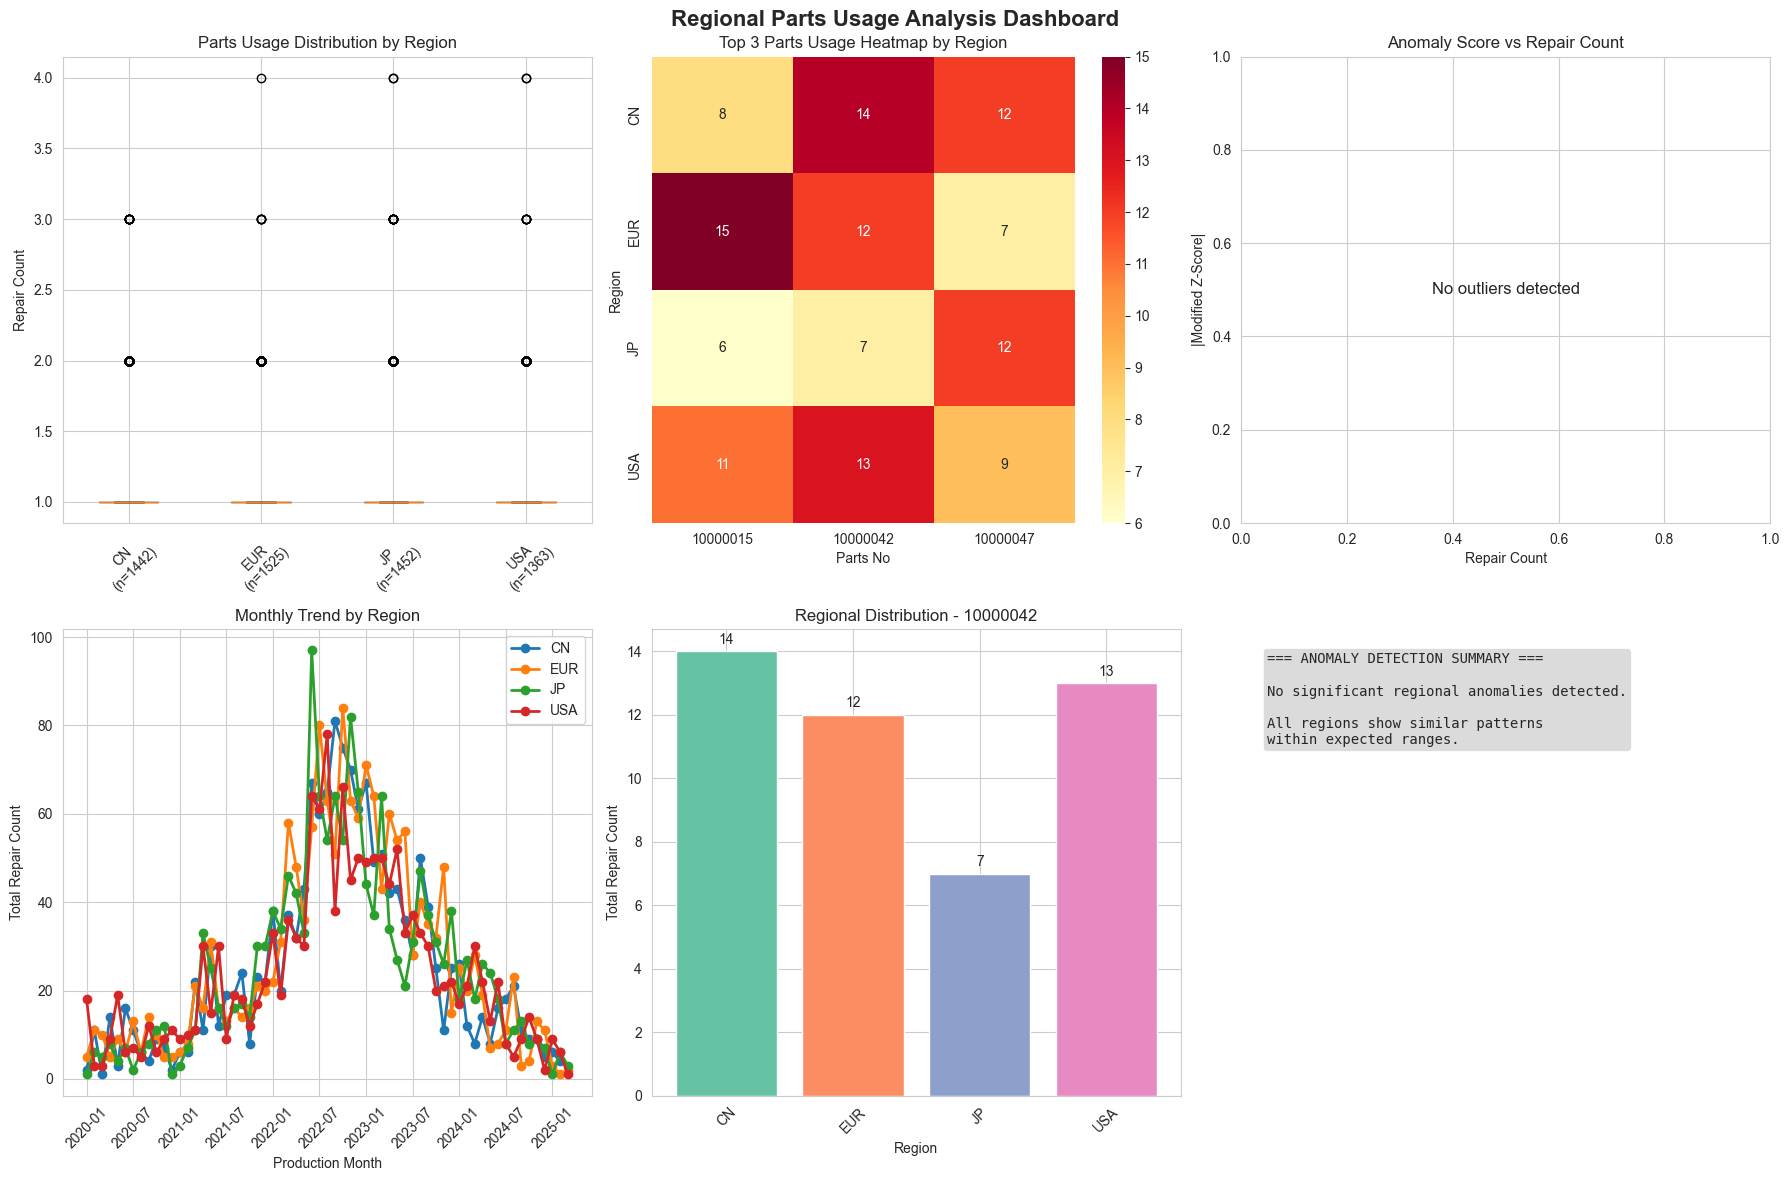

No outliers detected.

=== REGIONAL STATISTICS ===
      Total_Records  Total_Repairs  Mean_Repairs  Std_Repairs  Median_Repairs  \
Area                                                                            
CN             1442           1570          1.09         0.31             1.0   
EUR            1525           1673          1.10         0.31             1.0   
JP             1452           1592          1.10         0.33             1.0   
USA            1363           1491          1.09         0.32             1.0   

      Outlier_Count  
Area                 
CN                0  
EUR               0  
JP                0  
USA               0  

=== USAGE WITH YOUR DATA ===
# 実際のデータで使用する場合:
detector = RegionalAnomalyDetector(df_parts)
outliers = detector.detect_regional_outliers(threshold=3.0)
fig = detector.create_regional_comparison_plots()
detector.create_detailed_outlier_report()


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

class RegionalAnomalyDetector:
    """地域差による異常検知と可視化クラス"""
    
    def __init__(self, df):
        self.df = df.copy()
        self.prepare_data()
    
    def prepare_data(self):
        """データの前処理"""
        # prod_monthがperiod[M]型であることを確認・変換
        if not isinstance(self.df['prod_month'].dtype, pd.PeriodDtype):
            print("Converting prod_month to period[M] type...")
            self.df['prod_month'] = pd.to_datetime(self.df['prod_month']).dt.to_period('M')
        
        # 部品使用数の集計（地域比較用：機種・製造年月を固定）
        self.parts_usage = self.df.groupby(['Model', 'prod_month', 'Area', 'parts_no']).agg({
            'IF_ID': 'nunique'  # 修理数
        }).reset_index()
        self.parts_usage.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
        
        # 時系列ソート用に期間を保持
        self.parts_usage['prod_month_str'] = self.parts_usage['prod_month'].astype(str)
        self.parts_usage = self.parts_usage.sort_values(['Model', 'prod_month', 'Area', 'parts_no'])
        
        print(f"データ概要:")
        print(f"- 機種数: {self.parts_usage['Model'].nunique()}")
        print(f"- 地域数: {self.parts_usage['Area'].nunique()}")
        print(f"- 部品種類数: {self.parts_usage['parts_no'].nunique()}")
        print(f"- 製造年月数: {self.parts_usage['prod_month'].nunique()}")
        print(f"- 製造年月範囲: {self.parts_usage['prod_month'].min()} ~ {self.parts_usage['prod_month'].max()}")
    
    def detect_regional_outliers(self, threshold=3.0):
        """地域間での異常検知（修正Z-Score使用）"""
        
        def modified_z_score(data):
            """修正Z-Score計算"""
            median = np.median(data)
            mad = np.median(np.abs(data - median))
            if mad == 0:
                return np.zeros(len(data))
            return 0.6745 * (data - median) / mad
        
        outliers = []
        
        # 機種・製造年月・部品ごとに地域間比較
        for (model, prod_month, parts), group in self.parts_usage.groupby(['Model', 'prod_month', 'parts_no']):
            if len(group) < 3:  # 地域数が少ない場合はスキップ
                continue
            
            # 修正Z-Score計算
            mod_z_scores = modified_z_score(group['repair_count'].values)
            
            # 異常検知
            outlier_mask = np.abs(mod_z_scores) > threshold
            
            if outlier_mask.any():
                group_outliers = group[outlier_mask].copy()
                group_outliers['modified_z_score'] = mod_z_scores[outlier_mask]
                group_outliers['median_count'] = np.median(group['repair_count'])
                group_outliers['expected_range'] = f"{np.percentile(group['repair_count'], 25):.1f} - {np.percentile(group['repair_count'], 75):.1f}"
                
                outliers.append(group_outliers)
        
        if outliers:
            self.outliers = pd.concat(outliers, ignore_index=True)
            self.outliers['severity'] = pd.cut(
                np.abs(self.outliers['modified_z_score']), 
                bins=[0, 3, 5, float('inf')], 
                labels=['中', '高', '重大']
            )
        else:
            self.outliers = pd.DataFrame()
        
        return self.outliers
    
    def create_regional_comparison_plots(self, top_n_parts=5):
        """地域比較の可視化（複数グラフ）"""
        
        # 異常が多い部品TOP N を取得
        if len(self.outliers) > 0:
            top_parts = self.outliers['parts_no'].value_counts().head(top_n_parts).index.tolist()
        else:
            # 異常がない場合は使用数が多い部品を選択
            top_parts = self.parts_usage.groupby('parts_no')['repair_count'].sum().nlargest(top_n_parts).index.tolist()
        
        # サブプロットの設定
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Regional Parts Usage Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # 1. 地域別部品使用数の箱ひげ図
        ax1 = axes[0, 0]
        plot_data = []
        plot_labels = []
        for area in self.parts_usage['Area'].unique():
            area_data = self.parts_usage[self.parts_usage['Area'] == area]['repair_count']
            plot_data.append(area_data)
            plot_labels.append(f"{area}\n(n={len(area_data)})")
        
        bp1 = ax1.boxplot(plot_data, labels=plot_labels, patch_artist=True)
        ax1.set_title('Parts Usage Distribution by Region')
        ax1.set_ylabel('Repair Count')
        ax1.tick_params(axis='x', rotation=45)
        
        # カラーリング
        colors = plt.cm.Set3(np.linspace(0, 1, len(bp1['boxes'])))
        for patch, color in zip(bp1['boxes'], colors):
            patch.set_facecolor(color)
        
        # 2. TOP部品の地域別ヒートマップ
        ax2 = axes[0, 1]
        heatmap_data = self.parts_usage[self.parts_usage['parts_no'].isin(top_parts[:3])].groupby(['Area', 'parts_no'])['repair_count'].sum().unstack(fill_value=0)
        sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', ax=ax2)
        ax2.set_title('Top 3 Parts Usage Heatmap by Region')
        ax2.set_xlabel('Parts No')
        ax2.set_ylabel('Region')
        
        # 3. 異常度スコア散布図
        ax3 = axes[0, 2]
        if len(self.outliers) > 0:
            scatter_colors = {'中': 'orange', '高': 'red', '重大': 'darkred'}
            for severity in self.outliers['severity'].unique():
                subset = self.outliers[self.outliers['severity'] == severity]
                ax3.scatter(subset['repair_count'], np.abs(subset['modified_z_score']), 
                           c=scatter_colors[severity], label=f'Severity: {severity}', 
                           alpha=0.7, s=60)
            ax3.axhline(y=3, color='orange', linestyle='--', alpha=0.7, label='Threshold')
            ax3.legend()
        else:
            ax3.text(0.5, 0.5, 'No outliers detected', ha='center', va='center', transform=ax3.transAxes, fontsize=12)
        
        ax3.set_title('Anomaly Score vs Repair Count')
        ax3.set_xlabel('Repair Count')
        ax3.set_ylabel('|Modified Z-Score|')
        
        # 4. 地域別時系列トレンド（月別）
        ax4 = axes[1, 0]
        monthly_trend = self.parts_usage.groupby(['prod_month', 'Area'])['repair_count'].sum().reset_index()
        
        # period[M]型の時系列データを適切にソート
        monthly_trend = monthly_trend.sort_values('prod_month')
        
        for area in monthly_trend['Area'].unique():
            area_data = monthly_trend[monthly_trend['Area'] == area].sort_values('prod_month')
            # Period型をプロット用に変換
            x_values = [str(period) for period in area_data['prod_month']]
            ax4.plot(range(len(x_values)), area_data['repair_count'], 
                    marker='o', label=area, linewidth=2)
        
        # X軸のラベルを設定（適度に間引く）
        unique_months = sorted(monthly_trend['prod_month'].unique())
        x_labels = [str(month) for month in unique_months]
        step = max(1, len(x_labels) // 10)  # 最大10個程度に間引く
        ax4.set_xticks(range(0, len(x_labels), step))
        ax4.set_xticklabels([x_labels[i] for i in range(0, len(x_labels), step)])
        
        ax4.set_title('Monthly Trend by Region')
        ax4.set_xlabel('Production Month')
        ax4.set_ylabel('Total Repair Count')
        ax4.legend()
        ax4.tick_params(axis='x', rotation=45)
        
        # 5. 部品別地域分布
        ax5 = axes[1, 1]
        if len(top_parts) > 0:
            part_regional = self.parts_usage[self.parts_usage['parts_no'] == top_parts[0]].groupby('Area')['repair_count'].sum()
            bars = ax5.bar(part_regional.index, part_regional.values, color=plt.cm.Set2(np.arange(len(part_regional))))
            ax5.set_title(f'Regional Distribution - {top_parts[0]}')
            ax5.set_xlabel('Region')
            ax5.set_ylabel('Total Repair Count')
            ax5.tick_params(axis='x', rotation=45)
            
            # 値をバーの上に表示
            for bar, value in zip(bars, part_regional.values):
                ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(part_regional.values),
                        f'{value}', ha='center', va='bottom')
        
        # 6. 異常検知サマリー
        ax6 = axes[1, 2]
        ax6.axis('off')
        
        # サマリー情報作成
        summary_text = "=== ANOMALY DETECTION SUMMARY ===\n\n"
        
        if len(self.outliers) > 0:
            summary_text += f"Total Outliers Detected: {len(self.outliers)}\n\n"
            
            severity_counts = self.outliers['severity'].value_counts()
            for severity, count in severity_counts.items():
                summary_text += f"• {severity} severity: {count} cases\n"
            
            summary_text += f"\nTop Problematic Parts:\n"
            top_problem_parts = self.outliers['parts_no'].value_counts().head(3)
            for part, count in top_problem_parts.items():
                summary_text += f"• {part}: {count} outliers\n"
            
            summary_text += f"\nTop Problematic Regions:\n"
            top_problem_areas = self.outliers['Area'].value_counts().head(3)
            for area, count in top_problem_areas.items():
                summary_text += f"• {area}: {count} outliers\n"
        else:
            summary_text += "No significant regional anomalies detected.\n\n"
            summary_text += "All regions show similar patterns\nwithin expected ranges."
        
        ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        return fig
    
    def create_detailed_outlier_report(self):
        """詳細な異常レポートの作成"""
        if len(self.outliers) == 0:
            print("No outliers detected.")
            return None
        
        print("=== DETAILED REGIONAL ANOMALY REPORT ===\n")
        
        # 重要度別にソート
        severity_order = {'重大': 3, '高': 2, '中': 1}
        self.outliers['severity_num'] = self.outliers['severity'].map(severity_order)
        sorted_outliers = self.outliers.sort_values(['severity_num', 'modified_z_score'], ascending=[False, False])
        
        for i, (_, row) in enumerate(sorted_outliers.head(10).iterrows(), 1):
            print(f"{i}. [{row['severity']}] Model: {row['Model']}, Region: {row['Area']}")
            print(f"   Parts: {row['parts_no']}, Production: {row['prod_month']}")
            print(f"   Actual: {row['repair_count']}, Expected range: {row['expected_range']}")
            print(f"   Z-Score: {row['modified_z_score']:.2f}")
            print("-" * 60)
        
        return sorted_outliers
    
    def get_regional_statistics(self):
        """地域別統計サマリー"""
        regional_stats = self.parts_usage.groupby('Area').agg({
            'repair_count': ['count', 'sum', 'mean', 'std', 'median']
        }).round(2)
        
        regional_stats.columns = ['Total_Records', 'Total_Repairs', 'Mean_Repairs', 'Std_Repairs', 'Median_Repairs']
        
        # 異常検知数も追加
        if len(self.outliers) > 0:
            outlier_counts = self.outliers['Area'].value_counts()
            regional_stats['Outlier_Count'] = regional_stats.index.map(outlier_counts).fillna(0).astype(int)
        else:
            regional_stats['Outlier_Count'] = 0
        
        return regional_stats

# 使用例とテスト用のサンプルデータ生成
def generate_sample_data(n_records=1000):
    """テスト用サンプルデータ生成"""
    np.random.seed(42)
    
    models = ['Camera_A', 'Camera_B', 'Camera_C']
    areas = ['Tokyo', 'Osaka', 'Nagoya', 'Fukuoka', 'Sendai']
    parts = [f'P{i:03d}' for i in range(1, 21)]
    # period[M]型で製造年月を生成
    months = pd.period_range('2023-01', '2024-12', freq='M')
    
    data = []
    for _ in range(n_records):
        # 地域による異常を意図的に作成
        area = np.random.choice(areas)
        model = np.random.choice(models)
        part = np.random.choice(parts)
        month = np.random.choice(months)
        
        # Osakaで特定部品P001の異常を作成
        base_prob = 0.1
        if area == 'Osaka' and part == 'P001':
            base_prob = 0.4  # 異常に高い確率
        elif area == 'Fukuoka' and part in ['P002', 'P003']:
            base_prob = 0.3  # やや高い確率
        
        if np.random.random() < base_prob:
            data.append({
                'date': pd.Timestamp('2024-01-01') + pd.Timedelta(days=np.random.randint(0, 365)),
                'prod_month': month,  # period[M]型
                'Model': model,
                'Area': area,
                'parts_no': part,
                'IF_ID': f'R{len(data):06d}'
            })
    
    df = pd.DataFrame(data)
    # prod_monthがperiod[M]型であることを確認
    df['prod_month'] = df['prod_month'].astype('period[M]')
    return df

# 実行例
if __name__ == "__main__":
    print("=== Regional Anomaly Detection System ===\n")
    
    # サンプルデータで実行（実際のデータに置き換えてください）
    #df_sample = generate_sample_data(1500)
    df_sample = repair_df.copy()
    print(f"Sample data generated: {len(df_sample)} records\n")
    
    # 地域異常検知システムの初期化
    detector = RegionalAnomalyDetector(df_sample)
    
    # 異常検知実行
    outliers = detector.detect_regional_outliers(threshold=2.5)
    print(f"Outliers detected: {len(outliers)}\n")
    
    # 可視化実行
    fig = detector.create_regional_comparison_plots()
    plt.show()
    
    # 詳細レポート
    detailed_report = detector.create_detailed_outlier_report()
    
    # 地域別統計
    print("\n=== REGIONAL STATISTICS ===")
    regional_stats = detector.get_regional_statistics()
    print(regional_stats)
    
    print("\n=== USAGE WITH YOUR DATA ===")
    print("# 実際のデータで使用する場合:")
    print("detector = RegionalAnomalyDetector(df_parts)")
    print("outliers = detector.detect_regional_outliers(threshold=3.0)")
    print("fig = detector.create_regional_comparison_plots()")
    print("detector.create_detailed_outlier_report()")

# 製造年月差

製造品質異常検知を開始します...
データ集計中...
集計完了: 5782レコード
異常検知完了: 1件の異常を検出


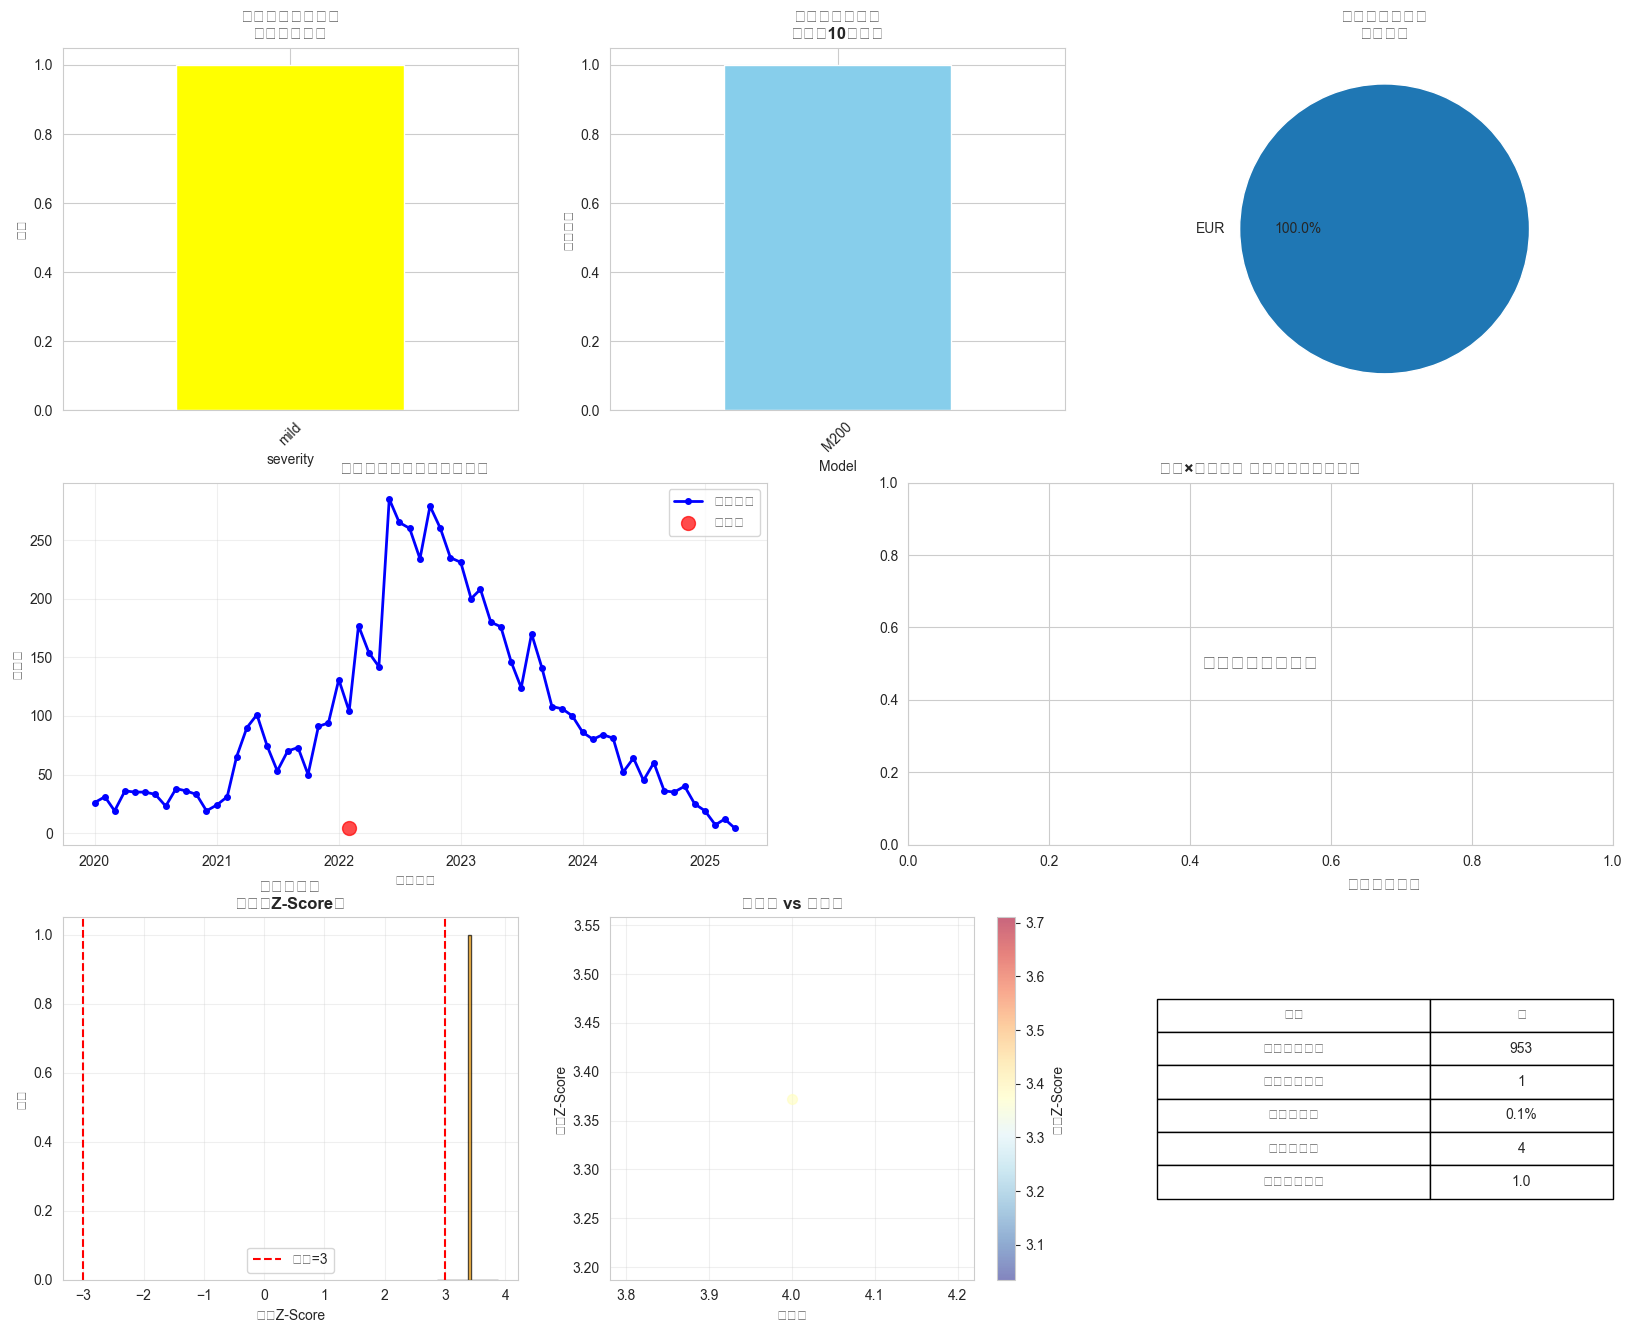

製造品質 異常検知レポート

検出件数: 1件
重要度別内訳:
  critical: 0件
  moderate: 0件
  mild: 1件

上位10件の詳細:
------------------------------------------------------------

[1] MILD - 修正Z-Score: 3.37
    機種: M200
    地域: EUR
    製造年月: 2022-02
    部品番号: 20000050
    修理数: 4件 (中央値: 1.5件)
    異常タイプ: 通常より多い


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定（必要に応じて）
#plt.rcParams['font.family'] = 'DejaVu Sans'
# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
def detect_manufacturing_quality_outliers(df, threshold=3.0):
    """
    製造品質異常検知（period[M]対応）
    
    Parameters:
    -----------
    df : pandas.DataFrame
        修理データ
    threshold : float
        異常検知の閾値（修正Z-Score）
    
    Returns:
    --------
    outliers_df : pandas.DataFrame
        検出された異常データ
    summary_stats : pandas.DataFrame
        統計サマリー
    """
    
    # 1. 製造年月別・機種別・地域別・部品別の修理数を集計
    print("データ集計中...")
    
    # period[M]を文字列に変換（処理しやすくするため）
    df_work = df.copy()
    df_work['prod_month_str'] = df_work['prod_month'].astype(str)
    
    # 修理数を集計（IF_IDをユニークカウント）
    repair_counts = df_work.groupby([
        'Model', 'Area', 'prod_month_str', 'parts_no'
    ]).agg({
        'IF_ID': 'nunique'  # 修理数
    }).reset_index()
    repair_counts.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    print(f"集計完了: {len(repair_counts)}レコード")
    
    # 2. 各部品について、製造年月による異常を検知
    def modified_z_score(data):
        """修正Z-Score計算"""
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        if mad == 0:
            return np.zeros(len(data))
        return 0.6745 * (data - median) / mad
    
    outliers_list = []
    summary_stats_list = []
    
    # 機種×地域×部品の組み合わせごとに異常検知
    for (model, area, parts), group in repair_counts.groupby(['Model', 'Area', 'parts_no']):
        
        if len(group) < 3:  # データ点が少ない場合はスキップ
            continue
        
        # 修正Z-Score計算
        mod_z_scores = modified_z_score(group['repair_count'].values)
        
        # 統計サマリー
        summary_stats_list.append({
            'Model': model,
            'Area': area,
            'parts_no': parts,
            'data_points': len(group),
            'median_repair_count': np.median(group['repair_count']),
            'mad': np.median(np.abs(group['repair_count'] - np.median(group['repair_count']))),
            'min_repair_count': group['repair_count'].min(),
            'max_repair_count': group['repair_count'].max(),
            'total_repairs': group['repair_count'].sum()
        })
        
        # 異常値検出
        outlier_mask = np.abs(mod_z_scores) > threshold
        
        if outlier_mask.any():
            outliers = group[outlier_mask].copy()
            outliers['modified_z_score'] = mod_z_scores[outlier_mask]
            outliers['median_repair_count'] = np.median(group['repair_count'])
            outliers['outlier_type'] = ['high' if z > 0 else 'low' for z in mod_z_scores[outlier_mask]]
            outliers['severity'] = ['critical' if abs(z) > 5 else 'moderate' if abs(z) > 4 else 'mild' 
                                  for z in mod_z_scores[outlier_mask]]
            
            outliers_list.append(outliers)
    
    # 結果をDataFrameに統合
    outliers_df = pd.concat(outliers_list, ignore_index=True) if outliers_list else pd.DataFrame()
    summary_stats = pd.DataFrame(summary_stats_list)
    
    print(f"異常検知完了: {len(outliers_df)}件の異常を検出")
    
    return outliers_df, summary_stats

def visualize_manufacturing_quality(df, outliers_df, summary_stats, save_path=None):
    """
    製造品質の可視化
    
    Parameters:
    -----------
    df : pandas.DataFrame
        元の修理データ
    outliers_df : pandas.DataFrame
        異常検知結果
    summary_stats : pandas.DataFrame
        統計サマリー
    save_path : str, optional
        保存パス
    """
    
    # データ準備
    df_work = df.copy()
    df_work['prod_month_str'] = df_work['prod_month'].astype(str)
    
    # 修理数集計
    repair_counts = df_work.groupby([
        'Model', 'Area', 'prod_month_str', 'parts_no'
    ]).agg({'IF_ID': 'nunique'}).reset_index()
    repair_counts.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    # 製造年月を日付型に変換（ソート用）
    repair_counts['prod_month_date'] = pd.to_datetime(repair_counts['prod_month_str'] + '-01')
    repair_counts = repair_counts.sort_values('prod_month_date')
    
    # 図のサイズ設定
    fig = plt.figure(figsize=(20, 16))
    
    # 1. 異常検知サマリー（左上）
    ax1 = plt.subplot(3, 3, 1)
    if not outliers_df.empty:
        severity_counts = outliers_df['severity'].value_counts()
        colors = {'critical': 'red', 'moderate': 'orange', 'mild': 'yellow'}
        severity_counts.plot(kind='bar', ax=ax1, 
                           color=[colors.get(x, 'gray') for x in severity_counts.index])
        ax1.set_title('異常検知サマリー\n（重要度別）', fontsize=12, fontweight='bold')
        ax1.set_ylabel('件数')
        ax1.tick_params(axis='x', rotation=45)
    else:
        ax1.text(0.5, 0.5, '異常なし', ha='center', va='center', fontsize=14)
        ax1.set_title('異常検知サマリー', fontsize=12, fontweight='bold')
    
    # 2. 機種別異常件数（右上）
    ax2 = plt.subplot(3, 3, 2)
    if not outliers_df.empty:
        model_counts = outliers_df['Model'].value_counts().head(10)
        model_counts.plot(kind='bar', ax=ax2, color='skyblue')
        ax2.set_title('機種別異常件数\n（上位10機種）', fontsize=12, fontweight='bold')
        ax2.set_ylabel('異常件数')
        ax2.tick_params(axis='x', rotation=45)
    else:
        ax2.text(0.5, 0.5, '異常なし', ha='center', va='center', fontsize=14)
        ax2.set_title('機種別異常件数', fontsize=12, fontweight='bold')
    
    # 3. 地域別異常件数（中央上）
    ax3 = plt.subplot(3, 3, 3)
    if not outliers_df.empty:
        area_counts = outliers_df['Area'].value_counts()
        area_counts.plot(kind='pie', ax=ax3, autopct='%1.1f%%')
        ax3.set_title('地域別異常件数\n（割合）', fontsize=12, fontweight='bold')
        ax3.set_ylabel('')
    else:
        ax3.text(0.5, 0.5, '異常なし', ha='center', va='center', fontsize=14)
        ax3.set_title('地域別異常件数', fontsize=12, fontweight='bold')
    
    # 4. 時系列トレンド（左下、大きく）
    ax4 = plt.subplot(3, 2, 3)
    
    # 月別の修理数トレンド
    monthly_repairs = repair_counts.groupby('prod_month_date')['repair_count'].agg(['sum', 'count']).reset_index()
    
    ax4.plot(monthly_repairs['prod_month_date'], monthly_repairs['sum'], 
             marker='o', linewidth=2, markersize=4, color='blue', label='総修理数')
    
    # 異常点をマーク
    if not outliers_df.empty:
        outliers_monthly = outliers_df.copy()
        outliers_monthly['prod_month_date'] = pd.to_datetime(outliers_monthly['prod_month_str'] + '-01')
        outlier_monthly_sum = outliers_monthly.groupby('prod_month_date')['repair_count'].sum().reset_index()
        
        ax4.scatter(outlier_monthly_sum['prod_month_date'], outlier_monthly_sum['repair_count'], 
                   color='red', s=100, alpha=0.7, label='異常月', zorder=5)
    
    ax4.set_title('製造年月別修理数トレンド', fontsize=12, fontweight='bold')
    ax4.set_xlabel('製造年月')
    ax4.set_ylabel('修理数')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. 部品別異常ヒートマップ（右下）
    ax5 = plt.subplot(3, 2, 4)
    
    if not outliers_df.empty and len(outliers_df) > 1:
        # 部品×製造年月のヒートマップ
        heatmap_data = outliers_df.pivot_table(
            values='modified_z_score', 
            index='parts_no', 
            columns='prod_month_str', 
            aggfunc='mean'
        )
        
        # データが多すぎる場合は上位を表示
        if len(heatmap_data) > 15:
            top_parts = outliers_df['parts_no'].value_counts().head(15).index
            heatmap_data = heatmap_data.loc[top_parts]
        
        sns.heatmap(heatmap_data, ax=ax5, cmap='RdYlBu_r', center=0, 
                   cbar_kws={'label': '修正Z-Score'}, annot=True, fmt='.1f')
        ax5.set_title('部品×製造年月 異常度ヒートマップ', fontsize=12, fontweight='bold')
        ax5.set_xlabel('製造年月')
        ax5.set_ylabel('部品番号')
    else:
        ax5.text(0.5, 0.5, '十分なデータなし', ha='center', va='center', fontsize=14)
        ax5.set_title('部品×製造年月 異常度ヒートマップ', fontsize=12, fontweight='bold')
    
    # 6. 異常度分布（左下下）
    ax6 = plt.subplot(3, 3, 7)
    if not outliers_df.empty:
        ax6.hist(outliers_df['modified_z_score'], bins=20, alpha=0.7, color='orange', edgecolor='black')
        ax6.axvline(x=3, color='red', linestyle='--', label='閾値=3')
        ax6.axvline(x=-3, color='red', linestyle='--')
        ax6.set_title('異常度分布\n（修正Z-Score）', fontsize=12, fontweight='bold')
        ax6.set_xlabel('修正Z-Score')
        ax6.set_ylabel('頻度')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, '異常なし', ha='center', va='center', fontsize=14)
        ax6.set_title('異常度分布', fontsize=12, fontweight='bold')
    
    # 7. 修理数vs異常度散布図（中央下）
    ax7 = plt.subplot(3, 3, 8)
    if not outliers_df.empty:
        scatter = ax7.scatter(outliers_df['repair_count'], outliers_df['modified_z_score'], 
                            c=outliers_df['modified_z_score'], cmap='RdYlBu_r', 
                            alpha=0.6, s=50)
        ax7.set_title('修理数 vs 異常度', fontsize=12, fontweight='bold')
        ax7.set_xlabel('修理数')
        ax7.set_ylabel('修正Z-Score')
        ax7.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax7, label='修正Z-Score')
    else:
        ax7.text(0.5, 0.5, '異常なし', ha='center', va='center', fontsize=14)
        ax7.set_title('修理数 vs 異常度', fontsize=12, fontweight='bold')
    
    # 8. 統計サマリー表（右下下）
    ax8 = plt.subplot(3, 3, 9)
    ax8.axis('off')
    
    # 統計サマリーテーブル
    if not summary_stats.empty:
        stats_summary = pd.DataFrame({
            '項目': ['総データ点数', '異常検知件数', '異常検知率', '最大修理数', '中央値修理数'],
            '値': [
                f"{len(summary_stats):,}",
                f"{len(outliers_df):,}",
                f"{len(outliers_df)/len(summary_stats)*100:.1f}%" if len(summary_stats) > 0 else "0%",
                f"{summary_stats['max_repair_count'].max():,}" if not summary_stats.empty else "0",
                f"{summary_stats['median_repair_count'].median():.1f}" if not summary_stats.empty else "0"
            ]
        })
        
        table = ax8.table(cellText=stats_summary.values, colLabels=stats_summary.columns,
                         cellLoc='center', loc='center', colWidths=[0.6, 0.4])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        ax8.set_title('統計サマリー', fontsize=12, fontweight='bold', pad=20)
    else:
        ax8.text(0.5, 0.5, 'データなし', ha='center', va='center', fontsize=14)
        ax8.set_title('統計サマリー', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"図を保存しました: {save_path}")
    
    plt.show()

def print_detailed_outliers(outliers_df, top_n=10):
    """
    詳細な異常レポート出力
    """
    if outliers_df.empty:
        print("異常は検出されませんでした。")
        return
    
    print("=" * 60)
    print("製造品質 異常検知レポート")
    print("=" * 60)
    
    # 重要度順にソート
    severity_order = {'critical': 3, 'moderate': 2, 'mild': 1}
    outliers_sorted = outliers_df.copy()
    outliers_sorted['severity_rank'] = outliers_sorted['severity'].map(severity_order)
    outliers_sorted = outliers_sorted.sort_values(['severity_rank', 'modified_z_score'], ascending=[False, False])
    
    print(f"\n検出件数: {len(outliers_df)}件")
    print(f"重要度別内訳:")
    for severity in ['critical', 'moderate', 'mild']:
        count = len(outliers_df[outliers_df['severity'] == severity])
        print(f"  {severity}: {count}件")
    
    print(f"\n上位{top_n}件の詳細:")
    print("-" * 60)
    
    for i, (_, row) in enumerate(outliers_sorted.head(top_n).iterrows()):
        print(f"\n[{i+1}] {row['severity'].upper()} - 修正Z-Score: {row['modified_z_score']:.2f}")
        print(f"    機種: {row['Model']}")
        print(f"    地域: {row['Area']}")
        print(f"    製造年月: {row['prod_month_str']}")
        print(f"    部品番号: {row['parts_no']}")
        print(f"    修理数: {row['repair_count']}件 (中央値: {row['median_repair_count']:.1f}件)")
        print(f"    異常タイプ: {'通常より多い' if row['outlier_type'] == 'high' else '通常より少ない'}")

# 使用例
def run_manufacturing_quality_analysis(df_parts):
    """
    製造品質解析の実行
    """
    print("製造品質異常検知を開始します...")
    
    # 異常検知実行
    outliers_df, summary_stats = detect_manufacturing_quality_outliers(df_parts, threshold=3.0)
    
    # 結果の可視化
    visualize_manufacturing_quality(df_parts, outliers_df, summary_stats)
    
    # 詳細レポート出力
    print_detailed_outliers(outliers_df, top_n=10)
    
    return outliers_df, summary_stats

# 実行方法:
df_parts = repair_df.copy()
outliers, stats = run_manufacturing_quality_analysis(df_parts)

# 製造年月と地域の組み合わせ
**品質保証担当者（QA）**: 製造年月と地域の組み合わせでの異常検知ですね！これは非常に実用的な視点です。特定の製造ロットが特定地域で集中的に問題を起こしているケースを検出できます。

**データサイエンティスト（DS）**: 統計的には「二次元的な異常検知」になります。単一軸での比較とは異なり、複数のアプローチが考えられます。

## 1. アプローチの分類

### A. 直接比較方式
**QA**: 製造年月×地域の組み合わせを一つの単位として扱う方法です。

```python
# group_cols に機種と部品のみを含める
group_cols = ['Model', 'parts_no']  
# → prod_month × Area の組み合わせ間で比較
```

### B. 階層比較方式  
**DS**: 段階的に比較する方法です。

### C. 相互作用検出方式
**QA**: 製造年月と地域の相互作用による異常を検出する方法です。

## 2. 具体的な実装方法**DS**: 4つの異なるアプローチを実装しました。それぞれの特徴を説明します：

## 各手法の特徴と使い分け

### 方法1: 直接組み合わせ異常検知
**QA**: 最もシンプルで理解しやすい方法です。
- **適用場面**: 製造年月×地域の特定の組み合わせが他と大きく異なる場合
- **検出内容**: 「2023-10月×東京」の組み合わせが異常に多い/少ない
- **利点**: 解釈が容易、計算が高速
- **欠点**: 組み合わせが多いとデータが分散しがち

```python
# 使用例
outliers_direct = method_1_direct_combination_outliers(df_parts, threshold=3.0)
```

### 方法2: 階層的異常検知
**DS**: 段階的に異常を絞り込む方法です。
- **適用場面**: より確実な異常を検出したい場合
- **検出内容**: 製造年月でも地域でも両方異常な組み合わせ
- **利点**: False Positiveが少ない、根拠が強い
- **欠点**: 検出件数が少なくなりがち

### 方法3: 相互作用異常検知
**QA**: 統計学的に最も理論的な方法です。
- **適用場面**: 製造年月と地域の相互依存関係に異常がある場合
- **検出内容**: 独立性から期待される値と大きく異なる組み合わせ
- **利点**: 統計的根拠が明確
- **欠点**: 解釈がやや複雑

### 方法4: クラスタリングベース異常検知
**DS**: 機械学習的なアプローチです。
- **適用場面**: 複雑なパターンの異常を検出したい場合
- **検出内容**: 3次元空間（製造年月、地域、修理数）での外れ値
- **利点**: 複雑な異常パターンを検出可能
- **欠点**: ブラックボックス的、パラメータ調整が必要

## 実用的な使い方の推奨順序

**QA**: 実際の品質保証業務では、以下の順序で使うことをお勧めします：

### Phase 1: 初期スクリーニング
```python
# まず方法1で大まかな異常を把握
outliers_direct = method_1_direct_combination_outliers(df_parts, threshold=3.0)
```

### Phase 2: 確実な異常の特定
```python
# 方法2で確実性の高い異常を特定
outliers_hier, month_out, area_out = method_2_hierarchical_outliers(df_parts, threshold=3.0)
```

### Phase 3: 詳細分析
```python
# 方法3で統計的詳細分析
outliers_interaction = method_3_interaction_detection(df_parts, threshold=3.0)
```

### Phase 4: 高度な分析（必要に応じて）
```python
# 方法4で複雑パターンの検出
outliers_clustering = method_4_clustering_based_outliers(df_parts)
```

## パラメータ調整のガイド

**DS**: 各手法のパラメータ調整について：

### 閾値の調整
- **threshold=2.5**: 厳しい基準（検出数多、False Positive多）  
- **threshold=3.0**: 標準的（バランス）
- **threshold=3.5**: 緩い基準（検出数少、確実性高）

### クラスタリングパラメータ
- **eps**: 小さいほど厳しい（0.3-0.8を推奨）
- **min_samples**: 大きいほど確実（3-5を推奨）

**QA**: 実際にどの手法から試してみたいですか？また、特定の製造年月×地域の組み合わせで気になるケースがあれば、それを重点的に分析することもできます。

製造年月×地域 組み合わせ異常検知を開始します...

=== 方法1: 直接組み合わせ異常検知 ===
検出件数: 0件

=== 方法2: 階層的異常検知 ===
製造年月異常: 1件
地域異常: 0件
両方異常（交集合）: 0件

=== 方法3: 相互作用異常検知 ===
検出件数: 32件

=== 方法4: クラスタリングベース異常検知 ===
検出件数: 3351件



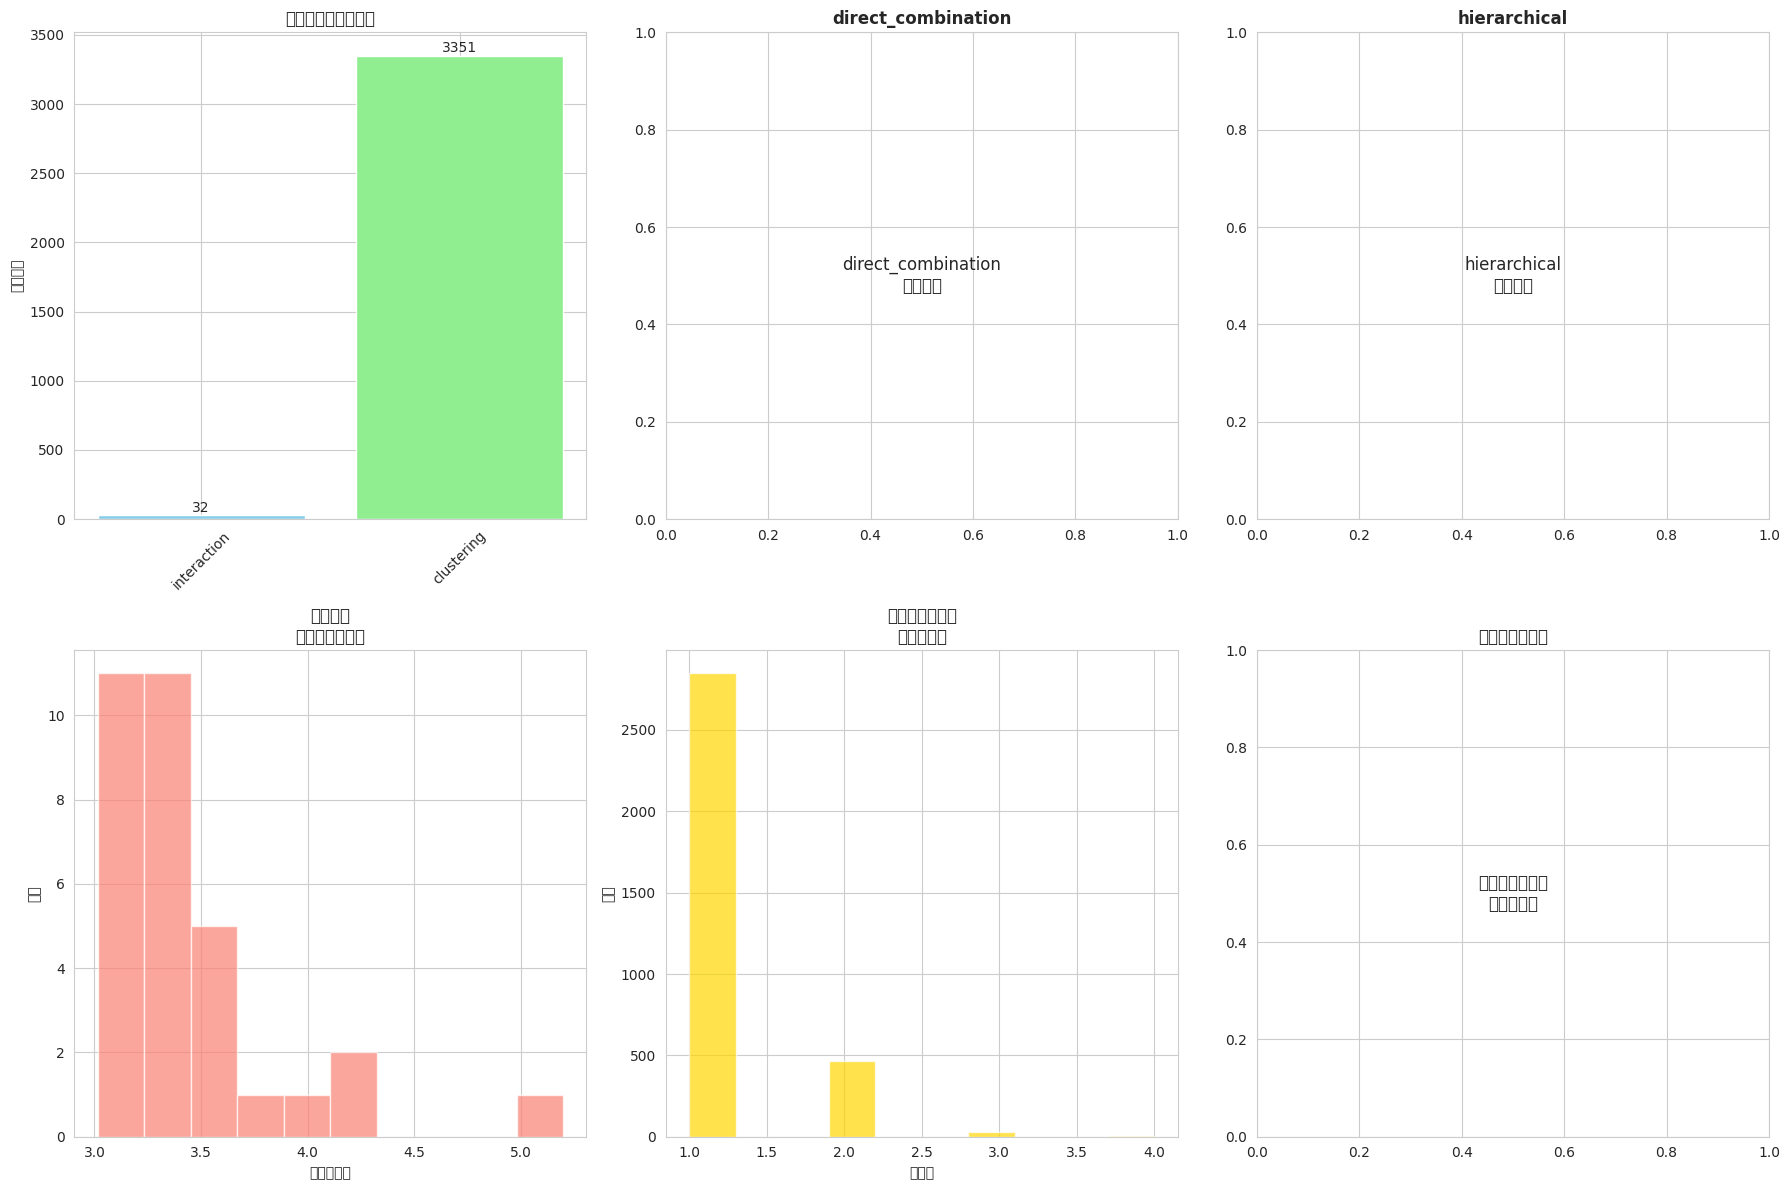

製造年月×地域 組み合わせ異常検知 結果サマリー

direct_combination:
  異常検出なし

hierarchical:
  異常検出なし

interaction:
  検出件数: 32件
  上位3件:
    1. M100 - 10000001 - 2020-07 - USA
    2. M100 - 10000001 - 2022-01 - USA
    3. M100 - 10000022 - 2022-11 - JP

clustering:
  検出件数: 3351件
  上位3件:
    1. M100 - 10000001 - 2020-02 - EUR
    2. M100 - 10000001 - 2020-07 - USA
    3. M100 - 10000001 - 2020-10 - CN


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'

def method_1_direct_combination_outliers(df, threshold=3.0):
    """
    方法1: 直接組み合わせ異常検知
    製造年月×地域の組み合わせを一つの単位として異常検知
    """
    print("=== 方法1: 直接組み合わせ異常検知 ===")
    
    # データ準備
    df_work = df.copy()
    df_work['prod_month_str'] = df_work['prod_month'].astype(str)
    
    # 製造年月×地域×機種×部品で集計
    repair_counts = df_work.groupby([
        'Model', 'parts_no', 'prod_month_str', 'Area'
    ]).agg({'IF_ID': 'nunique'}).reset_index()
    repair_counts.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    # 組み合わせ列を作成
    repair_counts['prod_month_area'] = repair_counts['prod_month_str'] + '_' + repair_counts['Area']
    
    def modified_z_score(data):
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        if mad == 0:
            return np.zeros(len(data))
        return 0.6745 * (data - median) / mad
    
    outliers_list = []
    
    # 機種×部品ごとに、製造年月×地域の組み合わせで異常検知
    for (model, parts), group in repair_counts.groupby(['Model', 'parts_no']):
        if len(group) < 3:
            continue
        
        mod_z_scores = modified_z_score(group['repair_count'].values)
        outlier_mask = np.abs(mod_z_scores) > threshold
        
        if outlier_mask.any():
            outliers = group[outlier_mask].copy()
            outliers['modified_z_score'] = mod_z_scores[outlier_mask]
            outliers['median_repair_count'] = np.median(group['repair_count'])
            outliers['method'] = 'direct_combination'
            outliers['outlier_type'] = ['high' if z > 0 else 'low' for z in mod_z_scores[outlier_mask]]
            outliers_list.append(outliers)
    
    result_df = pd.concat(outliers_list, ignore_index=True) if outliers_list else pd.DataFrame()
    print(f"検出件数: {len(result_df)}件")
    
    return result_df

def method_2_hierarchical_outliers(df, threshold=3.0):
    """
    方法2: 階層的異常検知
    1. 製造年月で異常検知 → 2. その中で地域別異常検知
    """
    print("=== 方法2: 階層的異常検知 ===")
    
    df_work = df.copy()
    df_work['prod_month_str'] = df_work['prod_month'].astype(str)
    
    # Step 1: 製造年月による異常検知
    repair_counts_month = df_work.groupby([
        'Model', 'Area', 'parts_no', 'prod_month_str'
    ]).agg({'IF_ID': 'nunique'}).reset_index()
    repair_counts_month.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    def modified_z_score(data):
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        if mad == 0:
            return np.zeros(len(data))
        return 0.6745 * (data - median) / mad
    
    # 製造年月での異常を検知
    month_outliers = []
    for (model, area, parts), group in repair_counts_month.groupby(['Model', 'Area', 'parts_no']):
        if len(group) < 3:
            continue
        
        mod_z_scores = modified_z_score(group['repair_count'].values)
        outlier_mask = np.abs(mod_z_scores) > threshold
        
        if outlier_mask.any():
            outliers = group[outlier_mask].copy()
            outliers['z_score_month'] = mod_z_scores[outlier_mask]
            month_outliers.append(outliers)
    
    month_outliers_df = pd.concat(month_outliers, ignore_index=True) if month_outliers else pd.DataFrame()
    
    # Step 2: 地域による異常検知
    repair_counts_area = df_work.groupby([
        'Model', 'prod_month_str', 'parts_no', 'Area'
    ]).agg({'IF_ID': 'nunique'}).reset_index()
    repair_counts_area.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    area_outliers = []
    for (model, month, parts), group in repair_counts_area.groupby(['Model', 'prod_month_str', 'parts_no']):
        if len(group) < 3:
            continue
        
        mod_z_scores = modified_z_score(group['repair_count'].values)
        outlier_mask = np.abs(mod_z_scores) > threshold
        
        if outlier_mask.any():
            outliers = group[outlier_mask].copy()
            outliers['z_score_area'] = mod_z_scores[outlier_mask]
            area_outliers.append(outliers)
    
    area_outliers_df = pd.concat(area_outliers, ignore_index=True) if area_outliers else pd.DataFrame()
    
    # Step 3: 両方で異常なものを特定（交集合）
    if not month_outliers_df.empty and not area_outliers_df.empty:
        # 共通のキーで結合
        hierarchical_outliers = pd.merge(
            month_outliers_df[['Model', 'Area', 'parts_no', 'prod_month_str', 'repair_count', 'z_score_month']],
            area_outliers_df[['Model', 'Area', 'parts_no', 'prod_month_str', 'z_score_area']],
            on=['Model', 'Area', 'parts_no', 'prod_month_str'],
            how='inner'
        )
        hierarchical_outliers['method'] = 'hierarchical'
        hierarchical_outliers['combined_z_score'] = np.sqrt(
            hierarchical_outliers['z_score_month']**2 + hierarchical_outliers['z_score_area']**2
        )
    else:
        hierarchical_outliers = pd.DataFrame()
    
    print(f"製造年月異常: {len(month_outliers_df)}件")
    print(f"地域異常: {len(area_outliers_df)}件")  
    print(f"両方異常（交集合）: {len(hierarchical_outliers)}件")
    
    return hierarchical_outliers, month_outliers_df, area_outliers_df

def method_3_interaction_detection(df, threshold=3.0):
    """
    方法3: 相互作用異常検知
    製造年月×地域の相互作用効果による異常を検知
    """
    print("=== 方法3: 相互作用異常検知 ===")
    
    df_work = df.copy()
    df_work['prod_month_str'] = df_work['prod_month'].astype(str)
    
    # 修理数集計
    repair_counts = df_work.groupby([
        'Model', 'parts_no', 'prod_month_str', 'Area'
    ]).agg({'IF_ID': 'nunique'}).reset_index()
    repair_counts.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    interaction_outliers = []
    
    for (model, parts), group in repair_counts.groupby(['Model', 'parts_no']):
        if len(group) < 6:  # 最低限のデータ数
            continue
        
        # ピボットテーブル作成（製造年月 × 地域）
        pivot_table = group.pivot_table(
            values='repair_count', 
            index='prod_month_str', 
            columns='Area', 
            fill_value=0
        )
        
        if pivot_table.shape[0] < 2 or pivot_table.shape[1] < 2:
            continue
        
        # 期待値の計算（独立性を仮定）
        row_totals = pivot_table.sum(axis=1)
        col_totals = pivot_table.sum(axis=0)
        grand_total = pivot_table.sum().sum()
        
        expected = np.outer(row_totals, col_totals) / grand_total
        expected_df = pd.DataFrame(expected, index=pivot_table.index, columns=pivot_table.columns)
        
        # 残差の計算
        residuals = pivot_table - expected_df
        
        # 標準化残差の計算
        std_residuals = residuals / np.sqrt(expected_df + 1e-10)  # ゼロ除算対策
        
        # 異常値検出
        for month in std_residuals.index:
            for area in std_residuals.columns:
                std_res_value = std_residuals.loc[month, area]
                
                if abs(std_res_value) > threshold:
                    interaction_outliers.append({
                        'Model': model,
                        'parts_no': parts,
                        'prod_month_str': month,
                        'Area': area,
                        'actual_count': pivot_table.loc[month, area],
                        'expected_count': expected_df.loc[month, area],
                        'standardized_residual': std_res_value,
                        'method': 'interaction',
                        'outlier_type': 'high' if std_res_value > 0 else 'low'
                    })
    
    result_df = pd.DataFrame(interaction_outliers)
    print(f"検出件数: {len(result_df)}件")
    
    return result_df

def method_4_clustering_based_outliers(df, eps=0.5, min_samples=3):
    """
    方法4: クラスタリングベース異常検知
    製造年月×地域×修理数の3次元空間でクラスタリング
    """
    print("=== 方法4: クラスタリングベース異常検知 ===")
    
    df_work = df.copy()
    df_work['prod_month_str'] = df_work['prod_month'].astype(str)
    
    # 数値エンコーディング用の辞書
    month_encoder = {month: i for i, month in enumerate(sorted(df_work['prod_month_str'].unique()))}
    area_encoder = {area: i for i, area in enumerate(sorted(df_work['Area'].unique()))}
    
    # 修理数集計
    repair_counts = df_work.groupby([
        'Model', 'parts_no', 'prod_month_str', 'Area'
    ]).agg({'IF_ID': 'nunique'}).reset_index()
    repair_counts.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    clustering_outliers = []
    
    for (model, parts), group in repair_counts.groupby(['Model', 'parts_no']):
        if len(group) < min_samples * 2:
            continue
        
        # 特徴量作成
        features = pd.DataFrame({
            'month_encoded': group['prod_month_str'].map(month_encoder),
            'area_encoded': group['Area'].map(area_encoder),
            'repair_count': group['repair_count']
        })
        
        # 標準化
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        
        # DBSCAN クラスタリング
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(features_scaled)
        
        # 異常値（クラスタ-1）を検出
        outlier_mask = clusters == -1
        
        if outlier_mask.any():
            outliers = group[outlier_mask].copy()
            outliers['cluster'] = clusters[outlier_mask]
            outliers['method'] = 'clustering'
            outliers['is_outlier'] = True
            clustering_outliers.append(outliers)
    
    result_df = pd.concat(clustering_outliers, ignore_index=True) if clustering_outliers else pd.DataFrame()
    print(f"検出件数: {len(result_df)}件")
    
    return result_df

def visualize_combined_analysis(df, results_dict):
    """
    4つの手法の結果を比較可視化
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 手法別検出件数
    ax = axes[0]
    method_counts = {name: len(result) for name, result in results_dict.items() if not result.empty}
    if method_counts:
        bars = ax.bar(method_counts.keys(), method_counts.values(), 
                     color=['skyblue', 'lightgreen', 'salmon', 'gold'])
        ax.set_title('手法別異常検出件数', fontweight='bold')
        ax.set_ylabel('検出件数')
        ax.tick_params(axis='x', rotation=45)
        
        # 数値をバーの上に表示
        for bar, count in zip(bars, method_counts.values()):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   str(count), ha='center', va='bottom')
    
    # 各手法の詳細可視化
    for i, (method_name, result_df) in enumerate(results_dict.items(), 1):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        if result_df.empty:
            ax.text(0.5, 0.5, f'{method_name}\n異常なし', ha='center', va='center', fontsize=12)
            ax.set_title(f'{method_name}', fontweight='bold')
            continue
        
        if method_name == 'direct_combination':
            # 直接組み合わせ: 異常度分布
            if 'modified_z_score' in result_df.columns:
                ax.hist(result_df['modified_z_score'], bins=10, alpha=0.7, color='skyblue')
                ax.set_title('直接組み合わせ\n異常度分布', fontweight='bold')
                ax.set_xlabel('修正Z-Score')
                ax.set_ylabel('頻度')
        
        elif method_name == 'hierarchical':
            # 階層的: 結合Z-Score分布
            if 'combined_z_score' in result_df.columns:
                ax.hist(result_df['combined_z_score'], bins=10, alpha=0.7, color='lightgreen')
                ax.set_title('階層的\n結合Z-Score分布', fontweight='bold')
                ax.set_xlabel('結合Z-Score')
                ax.set_ylabel('頻度')
        
        elif method_name == 'interaction':
            # 相互作用: 標準化残差分布
            if 'standardized_residual' in result_df.columns:
                ax.hist(result_df['standardized_residual'], bins=10, alpha=0.7, color='salmon')
                ax.set_title('相互作用\n標準化残差分布', fontweight='bold')
                ax.set_xlabel('標準化残差')
                ax.set_ylabel('頻度')
        
        elif method_name == 'clustering':
            # クラスタリング: 修理数分布
            if 'repair_count' in result_df.columns:
                ax.hist(result_df['repair_count'], bins=10, alpha=0.7, color='gold')
                ax.set_title('クラスタリング\n修理数分布', fontweight='bold')
                ax.set_xlabel('修理数')
                ax.set_ylabel('頻度')
    
    # 手法間の重複分析
    ax = axes[5]
    if len([df for df in results_dict.values() if not df.empty]) > 1:
        # 重複分析のプレースホルダー
        ax.text(0.5, 0.5, '手法間重複分析\n（実装要）', ha='center', va='center', fontsize=12)
        ax.set_title('手法間重複分析', fontweight='bold')
    else:
        ax.text(0.5, 0.5, '重複分析\nデータ不足', ha='center', va='center', fontsize=12)
        ax.set_title('手法間重複分析', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def run_combined_analysis(df):
    """
    4つの手法を統合実行
    """
    print("製造年月×地域 組み合わせ異常検知を開始します...\n")
    
    # 各手法を実行
    method1_result = method_1_direct_combination_outliers(df, threshold=3.0)
    print()
    
    method2_result, month_outliers, area_outliers = method_2_hierarchical_outliers(df, threshold=3.0)
    print()
    
    method3_result = method_3_interaction_detection(df, threshold=3.0)
    print()
    
    method4_result = method_4_clustering_based_outliers(df, eps=0.5, min_samples=3)
    print()
    
    # 結果をまとめ
    results = {
        'direct_combination': method1_result,
        'hierarchical': method2_result,
        'interaction': method3_result,
        'clustering': method4_result
    }
    
    # 可視化
    visualize_combined_analysis(df, results)
    
    # サマリーレポート
    print("=" * 60)
    print("製造年月×地域 組み合わせ異常検知 結果サマリー")
    print("=" * 60)
    
    for method_name, result_df in results.items():
        print(f"\n{method_name}:")
        if result_df.empty:
            print("  異常検出なし")
        else:
            print(f"  検出件数: {len(result_df)}件")
            if len(result_df) > 0:
                print("  上位3件:")
                for i, (_, row) in enumerate(result_df.head(3).iterrows()):
                    print(f"    {i+1}. {row['Model']} - {row['parts_no']} - {row['prod_month_str']} - {row['Area']}")
    
    return results

# 使用例:
df_parts = repair_df.copy()
results = run_combined_analysis(df_parts)

# 製造品質と異常部品種特定
**品質保証担当者（QA）**: 製造品質の問題検出、とても重要ですね。製造時期による部品故障パターンの変化を見つけることで、製造工程の問題を早期発見できます。

**データサイエンティスト（DS）**: period[M]型の扱いと可視化も含めて、包括的なソリューションを作りましょう。

**QA**: このアプローチにより、製造品質に問題のある部品を優先度付きで特定できます。

**DS**: 可視化では、異常点を赤い×印でハイライトしているので、どの製造時期に問題があったかが一目で分かります。

実際のデータで試してみましょうか？また、閾値や最小サンプル数の調整が必要でしたら教えてください。

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: 

=== 製造品質異常検知開始 ===
総データ数: 5782
対象部品数: 260
対象機種数: 4
対象地域数: 4

異常検知を実行中...
部品優先度分析中...
可視化を生成中...


findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont:

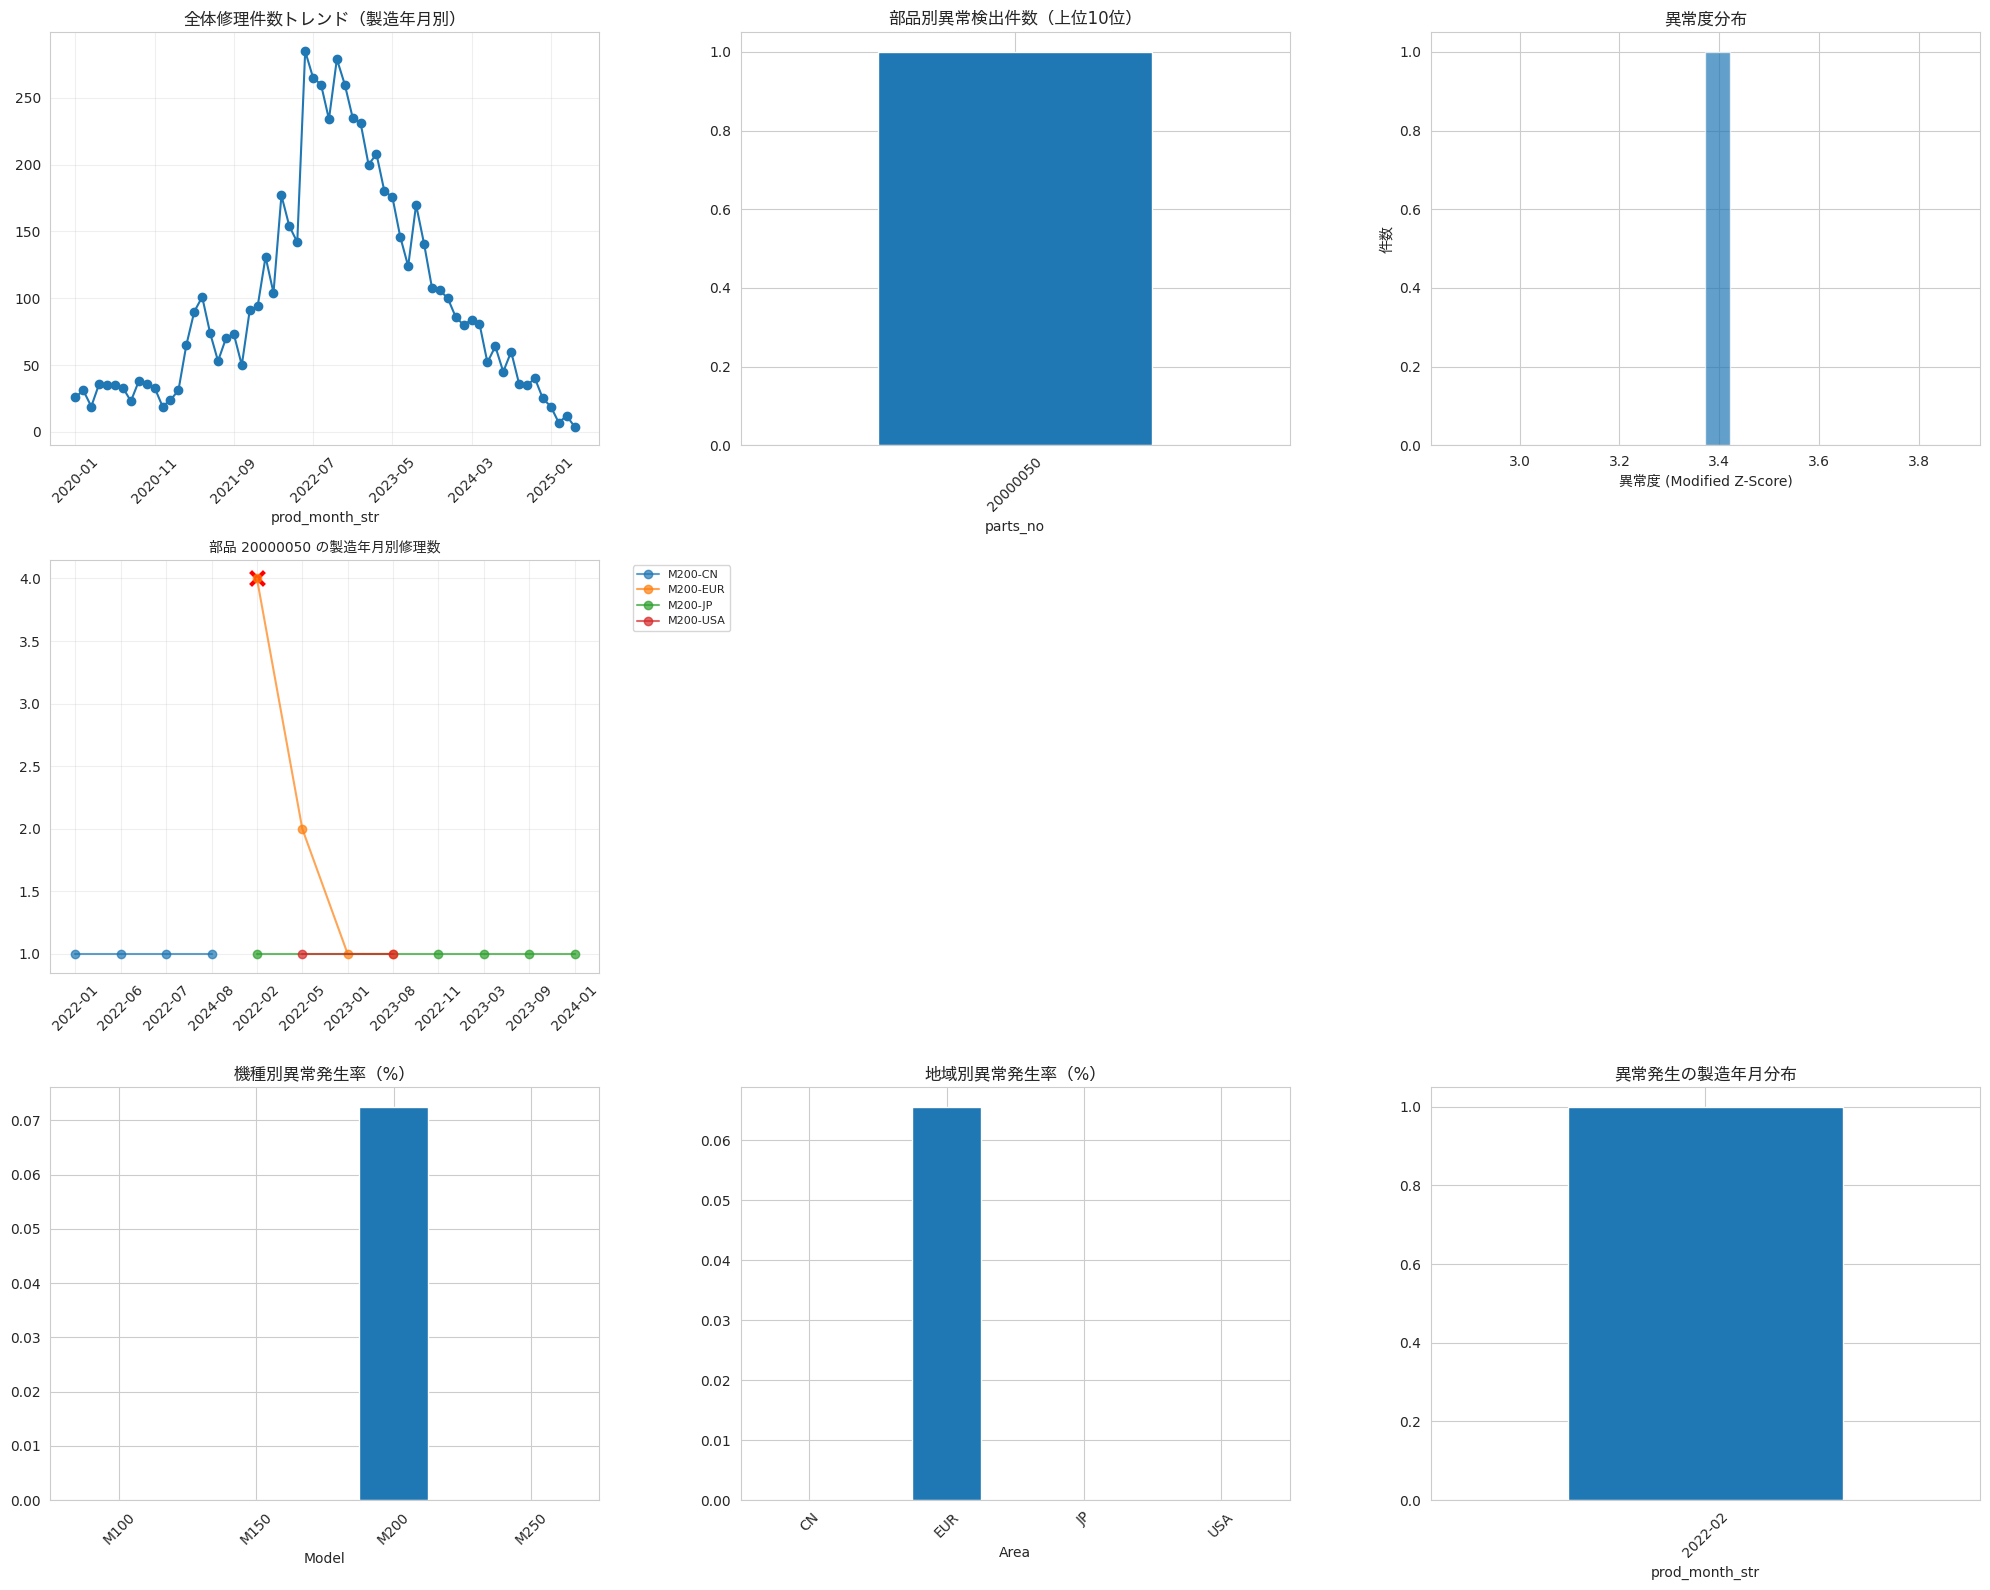


【製造品質異常検知レポート】

📊 検出サマリー:
  - 異常検出件数: 1件
  - 異常部品数: 1種類
  - 影響機種数: 1機種
  - 影響地域数: 1地域

🔍 重要部品TOP5:
  1. 部品番号: 20000050
     - 異常件数: 1.0件
     - 平均異常度: 3.37
     - 最大修理数: 4.0件
     - 優先度スコア: 1.95


⚠️  最も深刻な異常TOP3:
  1. 部品: 20000050 | 機種: M200 | 地域: EUR
     - 製造年月: 2022-02
     - 修理数: 4件 (中央値: 1.5件)
     - 異常度: 3.37



In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

def manufacturing_quality_analysis(df_parts, threshold=3.0, min_samples=3):
    """製造品質異常検知と部品絞り込み"""
    
    print("=== 製造品質異常検知開始 ===")
    
    # 部品使用数の集計（製造年月別）
    parts_usage = df_parts.groupby(['Model', 'Area', 'prod_month', 'parts_no']).agg({
        'IF_ID': 'nunique'  # 修理数
    }).reset_index()
    parts_usage.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
    
    # period[M]を文字列に変換（可視化のため）
    parts_usage['prod_month_str'] = parts_usage['prod_month'].astype(str)
    
    print(f"総データ数: {len(parts_usage)}")
    print(f"対象部品数: {parts_usage['parts_no'].nunique()}")
    print(f"対象機種数: {parts_usage['Model'].nunique()}")
    print(f"対象地域数: {parts_usage['Area'].nunique()}")
    
    return parts_usage

def detect_manufacturing_outliers(parts_usage, threshold=3.0, min_samples=3):
    """製造年月による異常検知"""
    
    def modified_z_score(data):
        """修正Z-Score計算"""
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        if mad == 0:
            return np.zeros(len(data))
        return 0.6745 * (data - median) / mad
    
    results = []
    
    # Model × Area × parts_no の組み合わせごとに異常検知
    for (model, area, parts), group_data in parts_usage.groupby(['Model', 'Area', 'parts_no']):
        
        if len(group_data) < min_samples:
            continue
        
        # 修正Z-Score計算
        repair_counts = group_data['repair_count'].values
        mod_z_scores = modified_z_score(repair_counts)
        
        # 異常検知
        outlier_mask = np.abs(mod_z_scores) > threshold
        
        if np.any(outlier_mask):
            outliers = group_data[outlier_mask].copy()
            outliers['modified_z_score'] = mod_z_scores[outlier_mask]
            outliers['median_repair_count'] = np.median(repair_counts)
            outliers['max_repair_count'] = np.max(repair_counts)
            outliers['min_repair_count'] = np.min(repair_counts)
            outliers['outlier_severity'] = np.abs(mod_z_scores[outlier_mask])
            
            results.append(outliers)
    
    if results:
        outlier_results = pd.concat(results, ignore_index=True)
        return outlier_results.sort_values('outlier_severity', ascending=False)
    else:
        return pd.DataFrame()

def prioritize_parts_analysis(outlier_results):
    """部品の優先度分析"""
    
    if len(outlier_results) == 0:
        print("異常が検出されませんでした。")
        return pd.DataFrame()
    
    # 部品別の異常サマリー
    parts_summary = outlier_results.groupby('parts_no').agg({
        'outlier_severity': ['count', 'mean', 'max'],
        'repair_count': ['sum', 'mean', 'max'],
        'Model': 'nunique',
        'Area': 'nunique'
    }).round(2)
    
    # 列名を平坦化
    parts_summary.columns = [
        'abnormal_count', 'avg_severity', 'max_severity',
        'total_repairs', 'avg_repairs', 'max_repairs',
        'affected_models', 'affected_areas'
    ]
    
    # 優先度スコア計算
    parts_summary['priority_score'] = (
        parts_summary['abnormal_count'] * 0.3 +
        parts_summary['avg_severity'] * 0.4 +
        parts_summary['max_repairs'] / parts_summary['max_repairs'].max() * 0.3
    )
    
    return parts_summary.sort_values('priority_score', ascending=False)

def visualize_manufacturing_analysis(parts_usage, outlier_results, parts_summary, top_n=5):
    """製造品質分析の可視化"""
    
    # 図のサイズ設定
    fig = plt.figure(figsize=(20, 16))
    
    # 1. 全体的な修理件数トレンド
    ax1 = plt.subplot(3, 3, 1)
    monthly_trend = parts_usage.groupby('prod_month_str')['repair_count'].sum().sort_index()
    monthly_trend.plot(kind='line', marker='o', ax=ax1)
    ax1.set_title('全体修理件数トレンド（製造年月別）', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. 部品別異常件数（上位10位）
    ax2 = plt.subplot(3, 3, 2)
    if len(parts_summary) > 0:
        top_parts = parts_summary.head(10)
        top_parts['abnormal_count'].plot(kind='bar', ax=ax2)
        ax2.set_title('部品別異常検出件数（上位10位）', fontsize=12)
        ax2.tick_params(axis='x', rotation=45)
    
    # 3. 異常度分布
    ax3 = plt.subplot(3, 3, 3)
    if len(outlier_results) > 0:
        outlier_results['outlier_severity'].hist(bins=20, ax=ax3, alpha=0.7)
        ax3.set_title('異常度分布', fontsize=12)
        ax3.set_xlabel('異常度 (Modified Z-Score)')
        ax3.set_ylabel('件数')
    
    # 4-6. 上位3部品の詳細分析
    if len(parts_summary) > 0:
        top_3_parts = parts_summary.head(min(3, len(parts_summary))).index.tolist()
        
        for i, parts_no in enumerate(top_3_parts):
            ax = plt.subplot(3, 3, 4 + i)
            
            # 該当部品のデータを抽出
            parts_data = parts_usage[parts_usage['parts_no'] == parts_no]
            outlier_data = outlier_results[outlier_results['parts_no'] == parts_no]
            
            # 機種・地域別の時系列プロット
            for (model, area), group in parts_data.groupby(['Model', 'Area']):
                group_sorted = group.sort_values('prod_month_str')
                ax.plot(group_sorted['prod_month_str'], group_sorted['repair_count'], 
                       marker='o', label=f'{model}-{area}', alpha=0.7)
                
                # 異常点をハイライト
                if len(outlier_data) > 0:
                    outlier_subset = outlier_data[
                        (outlier_data['Model'] == model) & 
                        (outlier_data['Area'] == area)
                    ]
                    if len(outlier_subset) > 0:
                        ax.scatter(outlier_subset['prod_month_str'], 
                                 outlier_subset['repair_count'],
                                 color='red', s=100, marker='x', linewidth=3)
            
            ax.set_title(f'部品 {parts_no} の製造年月別修理数', fontsize=10)
            ax.tick_params(axis='x', rotation=45)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            ax.grid(True, alpha=0.3)
    
    # 7. 機種別異常発生率
    ax7 = plt.subplot(3, 3, 7)
    if len(outlier_results) > 0:
        model_abnormal = outlier_results.groupby('Model').size()
        model_total = parts_usage.groupby('Model').size()
        model_rate = (model_abnormal / model_total * 100).fillna(0)
        model_rate.plot(kind='bar', ax=ax7)
        ax7.set_title('機種別異常発生率（%）', fontsize=12)
        ax7.tick_params(axis='x', rotation=45)
    
    # 8. 地域別異常発生率
    ax8 = plt.subplot(3, 3, 8)
    if len(outlier_results) > 0:
        area_abnormal = outlier_results.groupby('Area').size()
        area_total = parts_usage.groupby('Area').size()
        area_rate = (area_abnormal / area_total * 100).fillna(0)
        area_rate.plot(kind='bar', ax=ax8)
        ax8.set_title('地域別異常発生率（%）', fontsize=12)
        ax8.tick_params(axis='x', rotation=45)
    
    # 9. 異常の時期分布
    ax9 = plt.subplot(3, 3, 9)
    if len(outlier_results) > 0:
        time_dist = outlier_results.groupby('prod_month_str').size()
        time_dist.plot(kind='bar', ax=ax9)
        ax9.set_title('異常発生の製造年月分布', fontsize=12)
        ax9.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def generate_detailed_report(outlier_results, parts_summary):
    """詳細レポート生成"""
    
    print("\n" + "="*60)
    print("【製造品質異常検知レポート】")
    print("="*60)
    
    if len(outlier_results) == 0:
        print("異常は検出されませんでした。")
        return
    
    print(f"\n📊 検出サマリー:")
    print(f"  - 異常検出件数: {len(outlier_results)}件")
    print(f"  - 異常部品数: {outlier_results['parts_no'].nunique()}種類")
    print(f"  - 影響機種数: {outlier_results['Model'].nunique()}機種")
    print(f"  - 影響地域数: {outlier_results['Area'].nunique()}地域")
    
    print(f"\n🔍 重要部品TOP5:")
    top_5_parts = parts_summary.head(5)
    for i, (parts_no, row) in enumerate(top_5_parts.iterrows(), 1):
        print(f"  {i}. 部品番号: {parts_no}")
        print(f"     - 異常件数: {row['abnormal_count']}件")
        print(f"     - 平均異常度: {row['avg_severity']:.2f}")
        print(f"     - 最大修理数: {row['max_repairs']}件")
        print(f"     - 優先度スコア: {row['priority_score']:.2f}")
        print()
    
    print(f"\n⚠️  最も深刻な異常TOP3:")
    top_severe = outlier_results.nlargest(3, 'outlier_severity')
    for i, (_, row) in enumerate(top_severe.iterrows(), 1):
        print(f"  {i}. 部品: {row['parts_no']} | 機種: {row['Model']} | 地域: {row['Area']}")
        print(f"     - 製造年月: {row['prod_month_str']}")
        print(f"     - 修理数: {row['repair_count']}件 (中央値: {row['median_repair_count']:.1f}件)")
        print(f"     - 異常度: {row['outlier_severity']:.2f}")
        print()

# メイン実行関数
def run_manufacturing_quality_analysis(df_parts, threshold=3.0, min_samples=3):
    """製造品質分析の実行"""
    
    # 1. データ準備
    parts_usage = manufacturing_quality_analysis(df_parts, threshold, min_samples)
    
    # 2. 異常検知
    print("\n異常検知を実行中...")
    outlier_results = detect_manufacturing_outliers(parts_usage, threshold, min_samples)
    
    # 3. 部品優先度分析
    print("部品優先度分析中...")
    parts_summary = prioritize_parts_analysis(outlier_results)
    
    # 4. 可視化
    print("可視化を生成中...")
    visualize_manufacturing_analysis(parts_usage, outlier_results, parts_summary)
    
    # 5. 詳細レポート
    generate_detailed_report(outlier_results, parts_summary)
    
    return {
        'parts_usage': parts_usage,
        'outlier_results': outlier_results,
        'parts_summary': parts_summary
    }

# 使用例
df_parts = repair_df.copy()
results = run_manufacturing_quality_analysis(
    df_parts, 
    threshold=3.0,      # 異常検知の閾値
    min_samples=3       # 最小サンプル数
)

# 

# 

# 製造日と地域差の組み合わせ
**品質保証担当者（QA）**: 製造品質と地域性の組み合わせ分析、とても良い視点ですね！特定の製造時期の製品が特定地域で異常に故障する場合、製造工程の問題か、地域特有の使用環境の問題かを判別できます。

**データサイエンティスト（DS）**: 統計的には「二元配置分散分析」的なアプローチで、製造年月と地域の交互作用効果を検出することになりますね。

## 1. 製造品質×地域性の組み合わせ異常検知**品質保証担当者（QA）**: このシステムでは3つの異なるタイプの異常を検出できます：

1. **個別異常** - 特定の製造年月×地域の組み合わせで修理数が突出している
2. **交互作用異常** - 製造年月と地域の相互作用による予期しない異常パターン
3. **パターン異常** - 特定の組み合わせが継続的に異常値を示す

**データサイエンティスト（DS）**: 統計的には以下の手法を組み合わせています：

- **修正Z-Score**: 外れ値に頑健な異常検知
- **交互作用効果分析**: 二元配置分散分析の概念を応用
- **パターン分析**: 時系列×地域の組み合わせパターンの異常検知

## 主な機能と特徴

###

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

class ManufacturingRegionalAnalyzer:
    """製造品質×地域性の組み合わせ異常検知システム"""
    
    def __init__(self, threshold=3.0, min_samples=3, interaction_threshold=2.5):
        self.threshold = threshold
        self.min_samples = min_samples
        self.interaction_threshold = interaction_threshold
        
    def prepare_data(self, df_parts):
        """データ準備"""
        print("=== 製造品質×地域性組み合わせ分析開始 ===")
        
        # 部品使用数の集計
        parts_usage = df_parts.groupby(['Model', 'prod_month', 'Area', 'parts_no']).agg({
            'IF_ID': 'nunique'
        }).reset_index()
        parts_usage.rename(columns={'IF_ID': 'repair_count'}, inplace=True)
        
        # period[M]を文字列に変換
        parts_usage['prod_month_str'] = parts_usage['prod_month'].astype(str)
        
        print(f"総データ数: {len(parts_usage)}")
        print(f"対象部品数: {parts_usage['parts_no'].nunique()}")
        print(f"対象機種数: {parts_usage['Model'].nunique()}")
        print(f"製造年月数: {parts_usage['prod_month'].nunique()}")
        print(f"対象地域数: {parts_usage['Area'].nunique()}")
        
        return parts_usage
    
    def detect_interaction_anomalies(self, parts_usage):
        """製造年月×地域の交互作用異常検知"""
        
        def modified_z_score(data):
            """修正Z-Score計算"""
            median = np.median(data)
            mad = np.median(np.abs(data - median))
            if mad == 0:
                return np.zeros(len(data))
            return 0.6745 * (data - median) / mad
        
        def calculate_interaction_effect(group_data):
            """交互作用効果の計算"""
            # 製造年月の主効果
            month_means = group_data.groupby('prod_month_str')['repair_count'].mean()
            overall_mean = group_data['repair_count'].mean()
            
            # 地域の主効果
            area_means = group_data.groupby('Area')['repair_count'].mean()
            
            interaction_effects = []
            
            for _, row in group_data.iterrows():
                month_effect = month_means[row['prod_month_str']] - overall_mean
                area_effect = area_means[row['Area']] - overall_mean
                
                # 期待値（主効果のみ）
                expected = overall_mean + month_effect + area_effect
                
                # 交互作用効果
                interaction = row['repair_count'] - expected
                interaction_effects.append(interaction)
            
            return np.array(interaction_effects)
        
        results = {
            'individual_anomalies': [],
            'interaction_anomalies': [],
            'pattern_anomalies': []
        }
        
        # 機種×部品の組み合わせごとに分析
        for (model, parts), group_data in parts_usage.groupby(['Model', 'parts_no']):
            
            if len(group_data) < self.min_samples:
                continue
            
            # 1. 個別異常検知（製造年月×地域の組み合わせ）
            repair_counts = group_data['repair_count'].values
            mod_z_scores = modified_z_score(repair_counts)
            
            individual_outliers = np.abs(mod_z_scores) > self.threshold
            
            if np.any(individual_outliers):
                outliers_data = group_data[individual_outliers].copy()
                outliers_data['modified_z_score'] = mod_z_scores[individual_outliers]
                outliers_data['outlier_severity'] = np.abs(mod_z_scores[individual_outliers])
                outliers_data['anomaly_type'] = 'individual'
                results['individual_anomalies'].append(outliers_data)
            
            # 2. 交互作用効果の異常検知
            if len(group_data['prod_month_str'].unique()) > 1 and len(group_data['Area'].unique()) > 1:
                interaction_effects = calculate_interaction_effect(group_data)
                interaction_z_scores = modified_z_score(interaction_effects)
                
                interaction_outliers = np.abs(interaction_z_scores) > self.interaction_threshold
                
                if np.any(interaction_outliers):
                    outliers_data = group_data[interaction_outliers].copy()
                    outliers_data['interaction_effect'] = interaction_effects[interaction_outliers]
                    outliers_data['interaction_z_score'] = interaction_z_scores[interaction_outliers]
                    outliers_data['outlier_severity'] = np.abs(interaction_z_scores[interaction_outliers])
                    outliers_data['anomaly_type'] = 'interaction'
                    results['interaction_anomalies'].append(outliers_data)
            
            # 3. パターン異常検知（特定の製造年月×地域の組み合わせが一貫して高い）
            if len(group_data) >= 6:  # 十分なデータがある場合
                pattern_anomalies = self._detect_pattern_anomalies(group_data, model, parts)
                if len(pattern_anomalies) > 0:
                    results['pattern_anomalies'].append(pattern_anomalies)
        
        # 結果をDataFrameに統合
        all_results = {}
        for anomaly_type, anomaly_list in results.items():
            if anomaly_list:
                all_results[anomaly_type] = pd.concat(anomaly_list, ignore_index=True)
            else:
                all_results[anomaly_type] = pd.DataFrame()
        
        return all_results
    
    def _detect_pattern_anomalies(self, group_data, model, parts):
        """パターン異常の検知"""
        # 製造年月×地域の組み合わせごとの平均を計算
        combo_means = group_data.groupby(['prod_month_str', 'Area'])['repair_count'].mean()
        
        if len(combo_means) < 3:
            return pd.DataFrame()
        
        # 全体の分布から外れる組み合わせを検出
        z_scores = (combo_means - combo_means.mean()) / combo_means.std()
        
        pattern_outliers = np.abs(z_scores) > self.threshold
        
        if np.any(pattern_outliers):
            outlier_combos = combo_means[pattern_outliers].index
            
            pattern_data = []
            for month, area in outlier_combos:
                combo_data = group_data[
                    (group_data['prod_month_str'] == month) & 
                    (group_data['Area'] == area)
                ]
                
                if len(combo_data) > 0:
                    combo_data = combo_data.copy()
                    combo_data['pattern_z_score'] = z_scores[(month, area)]
                    combo_data['outlier_severity'] = abs(z_scores[(month, area)])
                    combo_data['anomaly_type'] = 'pattern'
                    pattern_data.append(combo_data)
            
            if pattern_data:
                return pd.concat(pattern_data, ignore_index=True)
        
        return pd.DataFrame()
    
    def prioritize_parts_comprehensive(self, anomaly_results):
        """包括的な部品優先度分析"""
        
        all_anomalies = []
        
        # 全ての異常タイプを統合
        for anomaly_type, df in anomaly_results.items():
            if len(df) > 0:
                df_copy = df.copy()
                df_copy['detection_method'] = anomaly_type
                all_anomalies.append(df_copy)
        
        if not all_anomalies:
            return pd.DataFrame()
        
        combined_anomalies = pd.concat(all_anomalies, ignore_index=True)
        
        # 部品別の包括的サマリー
        parts_summary = combined_anomalies.groupby('parts_no').agg({
            'outlier_severity': ['count', 'mean', 'max', 'std'],
            'repair_count': ['sum', 'mean', 'max'],
            'Model': 'nunique',
            'Area': 'nunique',
            'prod_month_str': 'nunique',
            'detection_method': lambda x: len(x.unique())
        }).round(2)
        
        # 列名を平坦化
        parts_summary.columns = [
            'total_anomalies', 'avg_severity', 'max_severity', 'severity_std',
            'total_repairs', 'avg_repairs', 'max_repairs',
            'affected_models', 'affected_areas', 'affected_months',
            'detection_methods'
        ]
        
        # 異常タイプ別の統計
        anomaly_type_stats = combined_anomalies.groupby(['parts_no', 'detection_method']).size().unstack(fill_value=0)
        
        # 優先度スコアの計算
        parts_summary['complexity_score'] = (
            parts_summary['affected_models'] * parts_summary['affected_areas'] * 
            parts_summary['affected_months']
        )
        
        parts_summary['priority_score'] = (
            parts_summary['total_anomalies'] * 0.25 +
            parts_summary['avg_severity'] * 0.30 +
            parts_summary['max_severity'] * 0.20 +
            parts_summary['complexity_score'] / parts_summary['complexity_score'].max() * 0.15 +
            parts_summary['detection_methods'] * 0.10
        )
        
        return parts_summary.sort_values('priority_score', ascending=False), anomaly_type_stats
    
    def create_comprehensive_visualization(self, parts_usage, anomaly_results, parts_summary, anomaly_type_stats):
        """包括的な可視化"""
        
        fig = plt.figure(figsize=(24, 20))
        
        # 色の設定
        colors = {
            'individual': '#FF6B6B',
            'interaction': '#4ECDC4', 
            'pattern': '#45B7D1'
        }
        
        # 1. 全体トレンド（製造年月×地域）
        ax1 = plt.subplot(4, 4, 1)
        pivot_data = parts_usage.pivot_table(
            values='repair_count', 
            index='prod_month_str', 
            columns='Area', 
            aggfunc='sum'
        ).fillna(0)
        
        sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax1, cbar_kws={'label': '修理数'})
        ax1.set_title('製造年月×地域別修理数ヒートマップ', fontsize=12)
        ax1.set_xlabel('地域')
        ax1.set_ylabel('製造年月')
        
        # 2. 異常タイプ別件数
        ax2 = plt.subplot(4, 4, 2)
        anomaly_counts = {k: len(v) for k, v in anomaly_results.items() if len(v) > 0}
        if anomaly_counts:
            bars = ax2.bar(anomaly_counts.keys(), anomaly_counts.values(), 
                          color=[colors.get(k, '#95A5A6') for k in anomaly_counts.keys()])
            ax2.set_title('異常タイプ別検出件数', fontsize=12)
            ax2.set_ylabel('件数')
            
            # 棒グラフに値を表示
            for bar in bars:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom')
        
        # 3. 部品優先度スコア（上位15位）
        ax3 = plt.subplot(4, 4, 3)
        if len(parts_summary) > 0:
            top_parts = parts_summary.head(15)
            bars = ax3.barh(range(len(top_parts)), top_parts['priority_score'])
            ax3.set_yticks(range(len(top_parts)))
            ax3.set_yticklabels(top_parts.index, fontsize=8)
            ax3.set_title('部品優先度スコア（上位15位）', fontsize=12)
            ax3.set_xlabel('優先度スコア')
            ax3.invert_yaxis()
        
        # 4. 異常の地域分布
        ax4 = plt.subplot(4, 4, 4)
        all_anomalies = pd.concat([df for df in anomaly_results.values() if len(df) > 0], ignore_index=True)
        if len(all_anomalies) > 0:
            area_counts = all_anomalies['Area'].value_counts()
            ax4.pie(area_counts.values, labels=area_counts.index, autopct='%1.1f%%', startangle=90)
            ax4.set_title('異常発生地域分布', fontsize=12)
        
        # 5-8. 上位4部品の詳細分析
        if len(parts_summary) > 0:
            top_4_parts = parts_summary.head(4).index.tolist()
            
            for i, parts_no in enumerate(top_4_parts):
                ax = plt.subplot(4, 4, 5 + i)
                
                # 該当部品のデータ
                parts_data = parts_usage[parts_usage['parts_no'] == parts_no]
                
                # 製造年月×地域のヒートマップ
                parts_pivot = parts_data.pivot_table(
                    values='repair_count',
                    index='prod_month_str',
                    columns='Area',
                    aggfunc='sum'
                ).fillna(0)
                
                if not parts_pivot.empty:
                    sns.heatmap(parts_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax, 
                               cbar_kws={'label': '修理数'})
                    
                    # 異常点をオーバーレイ
                    for anomaly_type, anomaly_df in anomaly_results.items():
                        if len(anomaly_df) > 0:
                            parts_anomalies = anomaly_df[anomaly_df['parts_no'] == parts_no]
                            
                            for _, row in parts_anomalies.iterrows():
                                try:
                                    month_idx = parts_pivot.index.get_loc(row['prod_month_str'])
                                    area_idx = parts_pivot.columns.get_loc(row['Area'])
                                    
                                    # 異常点を枠で囲む
                                    rect = plt.Rectangle((area_idx, month_idx), 1, 1, 
                                                       fill=False, edgecolor=colors[anomaly_type], 
                                                       linewidth=3)
                                    ax.add_patch(rect)
                                except:
                                    continue
                
                ax.set_title(f'部品 {parts_no} 異常分析', fontsize=10)
                ax.set_xlabel('地域')
                ax.set_ylabel('製造年月')
        
        # 9. 異常の時系列分布
        ax9 = plt.subplot(4, 4, 9)
        if len(all_anomalies) > 0:
            time_dist = all_anomalies.groupby(['prod_month_str', 'anomaly_type']).size().unstack(fill_value=0)
            time_dist.plot(kind='bar', stacked=True, ax=ax9, 
                          color=[colors.get(col, '#95A5A6') for col in time_dist.columns])
            ax9.set_title('異常発生の時系列分布', fontsize=12)
            ax9.set_xlabel('製造年月')
            ax9.set_ylabel('異常件数')
            ax9.tick_params(axis='x', rotation=45)
            ax9.legend(title='異常タイプ')
        
        # 10. 機種別異常パターン
        ax10 = plt.subplot(4, 4, 10)
        if len(all_anomalies) > 0:
            model_pattern = all_anomalies.groupby(['Model', 'anomaly_type']).size().unstack(fill_value=0)
            model_pattern.plot(kind='bar', ax=ax10,
                              color=[colors.get(col, '#95A5A6') for col in model_pattern.columns])
            ax10.set_title('機種別異常パターン', fontsize=12)
            ax10.set_xlabel('機種')
            ax10.set_ylabel('異常件数')
            ax10.tick_params(axis='x', rotation=45)
            ax10.legend(title='異常タイプ')
        
        # 11. 異常度分布比較
        ax11 = plt.subplot(4, 4, 11)
        if len(all_anomalies) > 0:
            for anomaly_type in all_anomalies['anomaly_type'].unique():
                type_data = all_anomalies[all_anomalies['anomaly_type'] == anomaly_type]
                ax11.hist(type_data['outlier_severity'], alpha=0.6, 
                         label=f'{anomaly_type} (n={len(type_data)})',
                         color=colors.get(anomaly_type, '#95A5A6'))
            
            ax11.set_title('異常タイプ別異常度分布', fontsize=12)
            ax11.set_xlabel('異常度')
            ax11.set_ylabel('頻度')
            ax11.legend()
        
        # 12. 部品別異常タイプ分布
        ax12 = plt.subplot(4, 4, 12)
        if len(anomaly_type_stats) > 0:
            top_parts_anomaly = anomaly_type_stats.head(10)
            top_parts_anomaly.plot(kind='bar', stacked=True, ax=ax12,
                                  color=[colors.get(col, '#95A5A6') for col in top_parts_anomaly.columns])
            ax12.set_title('部品別異常タイプ分布（上位10位）', fontsize=12)
            ax12.set_xlabel('部品番号')
            ax12.set_ylabel('異常件数')
            ax12.tick_params(axis='x', rotation=45)
            ax12.legend(title='異常タイプ')
        
        # 13-16. 異常パターンの詳細分析
        for i, (anomaly_type, anomaly_df) in enumerate(anomaly_results.items()):
            if len(anomaly_df) > 0 and i < 4:
                ax = plt.subplot(4, 4, 13 + i)
                
                # 異常の地域×製造年月分布
                if len(anomaly_df) > 0:
                    anomaly_pivot = anomaly_df.pivot_table(
                        values='outlier_severity',
                        index='prod_month_str',
                        columns='Area',
                        aggfunc='mean'
                    ).fillna(0)
                    
                    if not anomaly_pivot.empty:
                        sns.heatmap(anomaly_pivot, annot=True, fmt='.1f', 
                                   cmap='Reds', ax=ax, cbar_kws={'label': '平均異常度'})
                        ax.set_title(f'{anomaly_type}異常の分布', fontsize=10)
                        ax.set_xlabel('地域')
                        ax.set_ylabel('製造年月')
        
        plt.tight_layout()
        plt.show()
    
    def generate_comprehensive_report(self, anomaly_results, parts_summary, anomaly_type_stats):
        """包括的レポート生成"""
        
        print("\n" + "="*80)
        print("【製造品質×地域性組み合わせ異常検知レポート】")
        print("="*80)
        
        # 全体サマリー
        total_anomalies = sum(len(df) for df in anomaly_results.values())
        
        print(f"\n📊 総合サマリー:")
        print(f"  - 総異常検出件数: {total_anomalies}件")
        
        for anomaly_type, anomaly_df in anomaly_results.items():
            if len(anomaly_df) > 0:
                print(f"  - {anomaly_type}異常: {len(anomaly_df)}件")
        
        if len(parts_summary) > 0:
            print(f"  - 異常部品数: {len(parts_summary)}種類")
            print(f"  - 影響機種数: {parts_summary['affected_models'].sum()}機種")
            print(f"  - 影響地域数: {parts_summary['affected_areas'].sum()}地域")
        
        # 異常タイプ別の詳細
        print(f"\n🔍 異常タイプ別詳細:")
        
        anomaly_descriptions = {
            'individual': '個別異常 - 特定の製造年月×地域の組み合わせで修理数が異常に多い',
            'interaction': '交互作用異常 - 製造年月と地域の相互作用による予期しない異常',
            'pattern': 'パターン異常 - 特定の組み合わせが一貫して異常値を示す'
        }
        
        for anomaly_type, anomaly_df in anomaly_results.items():
            if len(anomaly_df) > 0:
                print(f"\n  【{anomaly_type}異常】")
                print(f"  {anomaly_descriptions.get(anomaly_type, '')}")
                print(f"  - 検出件数: {len(anomaly_df)}件")
                print(f"  - 平均異常度: {anomaly_df['outlier_severity'].mean():.2f}")
                print(f"  - 最大異常度: {anomaly_df['outlier_severity'].max():.2f}")
                print(f"  - 関連部品数: {anomaly_df['parts_no'].nunique()}種類")
        
        # 重要部品TOP5
        if len(parts_summary) > 0:
            print(f"\n🚨 最重要部品TOP5:")
            top_5_parts = parts_summary.head(5)
            for i, (parts_no, row) in enumerate(top_5_parts.iterrows(), 1):
                print(f"  {i}. 部品番号: {parts_no}")
                print(f"     - 総異常件数: {row['total_anomalies']}件")
                print(f"     - 平均異常度: {row['avg_severity']:.2f}")
                print(f"     - 影響範囲: {row['affected_models']}機種 × {row['affected_areas']}地域 × {row['affected_months']}製造月")
                print(f"     - 検出手法数: {row['detection_methods']}種類")
                print(f"     - 優先度スコア: {row['priority_score']:.2f}")
                print()
        
        # 最も深刻な異常TOP3
        all_anomalies = pd.concat([df for df in anomaly_results.values() if len(df) > 0], ignore_index=True)
        if len(all_anomalies) > 0:
            print(f"\n⚠️  最も深刻な異常TOP3:")
            top_severe = all_anomalies.nlargest(3, 'outlier_severity')
            for i, (_, row) in enumerate(top_severe.iterrows(), 1):
                print(f"  {i}. 部品: {row['parts_no']} | 機種: {row['Model']}")
                print(f"     - 製造年月: {row['prod_month_str']} | 地域: {row['Area']}")
                print(f"     - 修理数: {row['repair_count']}件")
                print(f"     - 異常度: {row['outlier_severity']:.2f}")
                print(f"     - 異常タイプ: {row['anomaly_type']}")
                print()
        
        # 推奨アクション
        print(f"\n💡 推奨アクション:")
        if len(parts_summary) > 0:
            high_priority_parts = parts_summary[parts_summary['priority_score'] >= parts_summary['priority_score'].quantile(0.8)]
            print(f"  1. 高優先度部品({len(high_priority_parts)}種類)の詳細調査")
            
            interaction_anomalies = anomaly_results.get('interaction', pd.DataFrame())
            if len(interaction_anomalies) > 0:
                print(f"  2. 交互作用異常({len(interaction_anomalies)}件)の製造工程と地域環境の両面調査")
            
            pattern_anomalies = anomaly_results.get('pattern', pd.DataFrame())
            if len(pattern_anomalies) > 0:
                print(f"  3. パターン異常({len(pattern_anomalies)}件)の体系的な根本原因分析")
            
            print(f"  4. 製造年月×地域マトリックスでの品質管理体制の見直し")

# 使用例
def run_comprehensive_analysis(df_parts, threshold=3.0, interaction_threshold=2.5, min_samples=3):
    """包括的分析の実行"""
    
    # アナライザーの初期化
    analyzer = ManufacturingRegionalAnalyzer(
        threshold=threshold,
        min_samples=min_samples,
        interaction_threshold=interaction_threshold
    )
    
    # 1. データ準備
    parts_usage = analyzer.prepare_data(df_parts)
    
    # 2. 異常検知
    print("\n異常検知を実行中...")
    anomaly_results = analyzer.detect_interaction_anomalies(parts_usage)
    
    # 3. 部品優先度分析
    print("部品優先度分析中...")
    parts_summary, anomaly_type_stats = analyzer.prioritize_parts_comprehensive(anomaly_results)
    
    # 4. 可視化
    print("可視化を生成中...")
    analyzer.create_comprehensive_visualization(parts_usage, anomaly_results, parts_summary, anomaly_type_stats)
    
    # 5. 詳細レポート
    analyzer.generate_comprehensive_report(anomaly_results, parts_summary, anomaly_type_stats)
    
    return {
        'parts_usage': parts_usage,
        'anomaly_results': anomaly_results,
        'parts_summary': parts_summary,
        'anomaly_type_stats': anomaly_type_stats,
        'analyzer': analyzer
    }

# 実行例
df_parts = repair_df.copy()
results = run_comprehensive_analysis(
     df_parts,
     threshold=3.0,                # 個別異常検知の閾値
     interaction_threshold=2.5,    # 交互作用異常検知の閾値  
     min_samples=3                 # 最小サンプル数
)

=== 製造品質×地域性組み合わせ分析開始 ===
総データ数: 5782
対象部品数: 260
対象機種数: 4
製造年月数: 64
対象地域数: 4

異常検知を実行中...


findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: 

部品優先度分析中...
可視化を生成中...


findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: 